# Final Project - Reinforcements Learning
Dear students,<br> this is the template notebook. Please copy it by clicking on the "File" tab and then on "Save a copy into drive".

---
<br>

### Name and ID:
Student 1: Erez Soffer, 209648682
<br><br>
<img src="https://play-lh.googleusercontent.com/e_oKlKPISbgdzut1H9opevS7-LTB8-8lsmpCdMkhlnqFenZhpjxbLmx7l158-xQQCIY">

### https://github.com/mpSchrader/gym-sokoban

# Installs

In [ ]:
%%capture
!sudo apt-get update
!sudo apt-get install -y xvfb ffmpeg freeglut3-dev
!pip install 'imageio==2.4.0'
!pip install gym
!pip install pygame
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet
!pip install gym
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install gym_sokoban
!pip install tensorflow
!git clone https://github.com/avivg7/sokoban-so.git
!unzip /content/sokoban-so/Compress.zip

# Imports

In [ ]:
import numpy as np
import gym
from gym import logger as gymlogger
from gym.utils import seeding
from gym import error, spaces, utils
gymlogger.set_level(40) # error only
from soko_pap import *
import glob
import io
import base64
import os
import random
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
from pyvirtualdisplay import Display
from IPython.display import HTML
from IPython import display as ipythondisplay
import pygame
import pyvirtualdisplay
import imageio
import IPython
import time
from collections import deque
import tensorflow as tf
from keras.optimizers import Adam
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Flatten, Input, Lambda, Concatenate
import keras.backend as K
import cv2

# Display utils
The cell below contains the video display configuration. No need to make changes here.

In [ ]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

Function - given an environment it will print us the details about observation, actions, agent's position and boxes locations

In [ ]:
def print_env_det(env):
  print(f'Observation space: {env.observation_space}'
      f'\nAction space: {env.action_space}'
      f'\nPlayer position:{env.player_position}'
      f'\nBox location: {find_box_location(env)}')

Function - given an environment it will return the indexes position and boxes locations

In [ ]:
def find_box_location(env):
    idx = np.argmax(env.room_state == 4)
    if env.room_state.flat[idx] == 4:
        return np.unravel_index(idx, env.room_state.shape)
    return None

# Feeling the Env

## EX1 - FIX SCENARIO -  PUSH & PULL - ONE BOX

Prioritized Experience Replay Buffer

In [ ]:
class PrioritizedReplayBuffer:
    def __init__(self, capacity, alpha=0.6):
        """
        Initialize the PrioritizedReplayBuffer.

        Parameters:
        capacity (int): The maximum number of transitions the buffer can hold.
        alpha (float): The exponent used to determine the priority of transitions.
        """
        self.capacity = capacity
        self.buffer = deque(maxlen=capacity)  # Store transitions
        self.priorities = deque(maxlen=capacity)  # Store priorities
        self.alpha = alpha  # Priority exponent

    def add(self, error, transition):
        """
        Add a new transition with a computed priority based on the given error.

        Parameters:
        error (float): The TD error of the transition.
        transition (object): The transition to be stored.
        """
        # Compute the priority of the transition
        priority = (np.abs(error) + 1e-5) ** self.alpha
        # Add transition and its priority to the buffer
        self.buffer.append(transition)
        self.priorities.append(priority)

    def sample(self, batch_size, beta=0.4):
        """
        Sample a batch of transitions with their priorities and compute the importance-sampling weights.

        Parameters:
        batch_size (int): The number of transitions to sample.
        beta (float): The exponent used to calculate the importance-sampling weights.

        Returns:
        samples (list): A batch of sampled transitions.
        indices (list): The indices of the sampled transitions.
        weights (list): The importance-sampling weights for the sampled transitions.
        """
        # Convert priorities to a numpy array for probability calculations
        scaled_priorities = np.array(self.priorities)
        if len(scaled_priorities) == 0:
            return [], [], []

        # Calculate the sampling probabilities
        sample_probs = scaled_priorities / scaled_priorities.sum()
        # Sample transitions based on the calculated probabilities
        indices = np.random.choice(len(self.buffer), batch_size, p=sample_probs)
        samples = [self.buffer[idx] for idx in indices]

        total = len(self.buffer)
        # Calculate the importance-sampling weights
        weights = (total * sample_probs[indices]) ** (-beta)
        weights /= weights.max()  # Normalize weights

        return samples, indices, weights

    def update_priorities(self, indices, errors):
        """
        Update the priorities of the sampled transitions based on their new errors.

        Parameters:
        indices (list): The indices of the transitions to update.
        errors (list): The new errors of the transitions.
        """
        for idx, error in zip(indices, errors):
            # Update the priority of each transition
            self.priorities[idx] = (np.abs(error) + 1e-5) ** self.alpha

Double Q-Learning Agent with Prioritized Experience Replay

In [ ]:
class DoubleQLearningAgent:
    def __init__(self, action_space, learning_rate=0.1, discount_factor=0.9, exploration_rate=1.0, exploration_decay=0.995, exploration_min=0, memory_size=10000, batch_size=64):
        """
        Initialize the DoubleQLearningAgent.

        Parameters:
        action_space (int): The number of possible actions.
        learning_rate (float): The learning rate for updating Q-values.
        discount_factor (float): The discount factor for future rewards.
        exploration_rate (float): The initial exploration rate for epsilon-greedy policy.
        exploration_decay (float): The decay rate of the exploration rate.
        exploration_min (float): The minimum exploration rate.
        memory_size (int): The maximum size of the replay buffer.
        batch_size (int): The batch size for replaying experiences.
        """
        self.action_space = action_space
        self.q_table1 = {}  # First Q-table
        self.q_table2 = {}  # Second Q-table
        self.lr = learning_rate  # Learning rate
        self.gamma = discount_factor  # Discount factor
        self.epsilon = exploration_rate  # Exploration rate
        self.epsilon_decay = exploration_decay  # Exploration decay rate
        self.epsilon_min = exploration_min  # Minimum exploration rate
        self.memory = PrioritizedReplayBuffer(memory_size)  # Replay buffer
        self.batch_size = batch_size  # Batch size for replay

    def choose_action(self, state):
        """
        Choose an action based on the current state using epsilon-greedy policy.

        Parameters:
        state (tuple): The current state.

        Returns:
        action (int): The chosen action.
        """
        if np.random.rand() < self.epsilon:
            # Choose a random action
            return np.random.choice(self.action_space)
        # Compute Q-values by summing Q-values from both Q-tables
        q_values = np.add(self.q_table1.get(state, np.zeros(self.action_space)), self.q_table2.get(state, np.zeros(self.action_space)))
        # Choose the action with the highest Q-value
        return np.argmax(q_values)

    def learn(self, state, action, reward, next_state, done):
        """
        Update Q-values based on the transition and compute the TD error.

        Parameters:
        state (tuple): The current state.
        action (int): The action taken.
        reward (float): The reward received.
        next_state (tuple): The next state.
        done (bool): Whether the episode is finished.

        Returns:
        error (float): The temporal difference error.
        """
        # Initialize Q-values for the current state and next state if not present
        if state not in self.q_table1:
            self.q_table1[state] = np.zeros(self.action_space)
        if state not in self.q_table2:
            self.q_table2[state] = np.zeros(self.action_space)
        if next_state not in self.q_table1:
            self.q_table1[next_state] = np.zeros(self.action_space)
        if next_state not in self.q_table2:
            self.q_table2[next_state] = np.zeros(self.action_space)

        # Randomly update one of the Q-tables
        if np.random.rand() < 0.5:
            q_update = reward + self.gamma * self.q_table2[next_state][np.argmax(self.q_table1[next_state])] * (1 - done)
            error = q_update - self.q_table1[state][action]
            self.q_table1[state][action] += self.lr * np.clip(error, -1, 1)
        else:
            q_update = reward + self.gamma * self.q_table1[next_state][np.argmax(self.q_table2[next_state])] * (1 - done)
            error = q_update - self.q_table2[state][action]
            self.q_table2[state][action] += self.lr * np.clip(error, -1, 1)

        # Update the exploration rate
        if done:
            self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

        return error

    def remember(self, state, action, reward, next_state, done):
        """
        Store the transition in the replay buffer with a computed priority.

        Parameters:
        state (tuple): The current state.
        action (int): The action taken.
        reward (float): The reward received.
        next_state (tuple): The next state.
        done (bool): Whether the episode is finished.
        """
        # Initialize Q-values for the current state if not present
        if state not in self.q_table1:
            self.q_table1[state] = np.zeros(self.action_space)
        if state not in self.q_table2:
            self.q_table2[state] = np.zeros(self.action_space)

        # Compute the current Q-values by summing Q-values from both Q-tables
        q_values = np.add(self.q_table1[state], self.q_table2[state])
        # Compute the TD error
        error = abs(reward + self.gamma * np.max(q_values) * (1 - done) - q_values[action])
        # Add the transition and its priority to the replay buffer
        self.memory.add(error, (state, action, reward, next_state, done))

    def replay(self):
        """
        Perform experience replay to update the Q-values using the transitions in the replay buffer.
        """
        # Check if there are enough samples to form a batch
        if len(self.memory.buffer) < self.batch_size:
            return

        # Sample a batch of transitions from the replay buffer
        batch, indices, weights = self.memory.sample(self.batch_size)
        errors = []
        # Update Q-values based on each transition in the batch
        for i, (state, action, reward, next_state, done) in enumerate(batch):
            error = self.learn(state, action, reward, next_state, done)
            errors.append(error)

        # Update the priorities of the sampled transitions
        self.memory.update_priorities(indices, errors)

Converting observation to state for Q-Table

In [ ]:
def convert_observation_to_state(observation):
    """
    Convert an observation to a unique state representation.

    Parameters:
    observation (np.ndarray): The observation to convert.

    Returns:
    state (int): A unique hash representing the observation.
    """
    # Convert the observation to bytes and hash it to get a unique state representation
    return hash(observation.tobytes())

Training function with experience replay

In [ ]:
def train_agent(env, agent, episodes=1000, convergence_window=50, convergence_threshold=10, std_threshold=0.1, patience=5):
    """
    Train the DoubleQLearningAgent in the given environment.

    Parameters:
    env (gym.Env): The environment in which the agent will be trained.
    agent (DoubleQLearningAgent): The agent to be trained.
    episodes (int): The number of episodes for training.
    convergence_window (int): The window size for checking convergence.
    convergence_threshold (float): The threshold for average reward to consider convergence.
    std_threshold (float): The threshold for standard deviation of rewards to consider convergence.
    patience (int): The number of consecutive windows to meet the criteria before declaring convergence.

    Returns:
    rewards (list): List of total rewards for each episode.
    avg_rewards (list): List of average rewards for the convergence window.
    """
    rewards = []
    avg_rewards = []
    recent_rewards = deque(maxlen=convergence_window)  # Track recent rewards for convergence check
    convergence_count = 0

    for episode in range(episodes):
        # Seed the environment for reproducibility
        random.seed(2)
        env = PushAndPullSokobanEnv(dim_room=(7, 7), num_boxes=1, max_steps=500)
        random.seed(episode)
        state = convert_observation_to_state(env.room_state.copy())
        total_reward = 0
        done = False
        step_count = 0

        while not done:
            # Choose an action based on the current state
            action = agent.choose_action(state)
            # Perform the action in the environment
            next_state, reward, done, _ = env.step(action)
            next_state = convert_observation_to_state(next_state)

            # Store the transition in memory and learn from it
            agent.remember(state, action, reward, next_state, done)
            agent.learn(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            step_count += 1

        # Perform experience replay
        agent.replay()
        rewards.append(total_reward)
        recent_rewards.append(total_reward)

        # Calculate recent average and standard deviation of rewards
        avg_recent_reward = np.mean(recent_rewards) if recent_rewards else 0
        std_recent_reward = np.std(recent_rewards) if recent_rewards else 0
        avg_rewards.append(avg_recent_reward)

        # Check for convergence
        if len(recent_rewards) == convergence_window:
            if avg_recent_reward >= convergence_threshold and std_recent_reward <= std_threshold:
                convergence_count += 1
                print(f"Convergence check: Episode {episode + 1}, Avg Reward: {avg_recent_reward}, Std Dev: {std_recent_reward}, Count: {convergence_count}/{patience}")
                if convergence_count >= patience:
                    print(f"Training converged at episode {episode + 1}")
                    break
            else:
                convergence_count = 0  # Reset the count if not consistently converged

        if (episode + 1) % 100 == 0 or convergence_count > 0:
            print(f"Episode {episode + 1}/{episodes} - Reward: {total_reward}, Avg Reward: {avg_recent_reward}, Std Dev: {std_recent_reward}, Steps: {step_count}")

        # Update the exploration rate
        if agent.epsilon > agent.epsilon_min:
            agent.epsilon *= agent.epsilon_decay

    return rewards, avg_rewards

In [ ]:
#=============== DO NOT DELETE ===============
random.seed(2)
sok = PushAndPullSokobanEnv(dim_room=(7, 7),num_boxes=1 ,max_steps=500)
# ============================================

Observation space: Box(0.0, 255.0, (112, 112, 3), float32)
Action space: Discrete(13)
Player position:[1 1]
Box location: (2, 2)


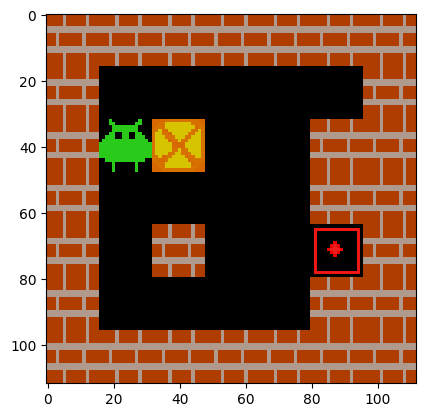

In [ ]:
screen = sok.render(mode='rgb_array')
plt.imshow(sok.render('rgb_array'))
observation, reward, done, _ = sok.step(1)
print_env_det(sok)

Training the agent for EX1

In [ ]:
# Create an instance of the DoubleQLearningAgent with the specified action space
agent_ex1 = DoubleQLearningAgent(action_space=sok.action_space.n)

# Train the agent in the Sokoban environment
# rewards_ex1 will store the total rewards for each episode
# avg_rewards_ex1 will store the average rewards over the convergence window
rewards_ex1, avg_rewards_ex1 = train_agent(sok, agent_ex1)

Episode 100/1000 - Reward: 5.300000000000004, Avg Reward: -42.08400000000037, Std Dev: 16.011375456218765, Steps: 57
Episode 200/1000 - Reward: -10.600000000000035, Avg Reward: -26.85000000000024, Std Dev: 23.160356214877385, Steps: 216
Episode 300/1000 - Reward: 10.0, Avg Reward: 0.521999999999935, Std Dev: 20.925374930930303, Steps: 10
Convergence check: Episode 354, Avg Reward: 10.078000000000001, Std Dev: 0.07820485918406854, Count: 1/5
Episode 354/1000 - Reward: 10.1, Avg Reward: 10.078000000000001, Std Dev: 0.07820485918406854, Steps: 9
Convergence check: Episode 355, Avg Reward: 10.078000000000001, Std Dev: 0.07820485918406854, Count: 2/5
Episode 355/1000 - Reward: 10.1, Avg Reward: 10.078000000000001, Std Dev: 0.07820485918406854, Steps: 9
Convergence check: Episode 356, Avg Reward: 10.080000000000002, Std Dev: 0.07745966692414827, Count: 3/5
Episode 356/1000 - Reward: 10.1, Avg Reward: 10.080000000000002, Std Dev: 0.07745966692414827, Steps: 9
Convergence check: Episode 357, A

Displaying training progress for EX1

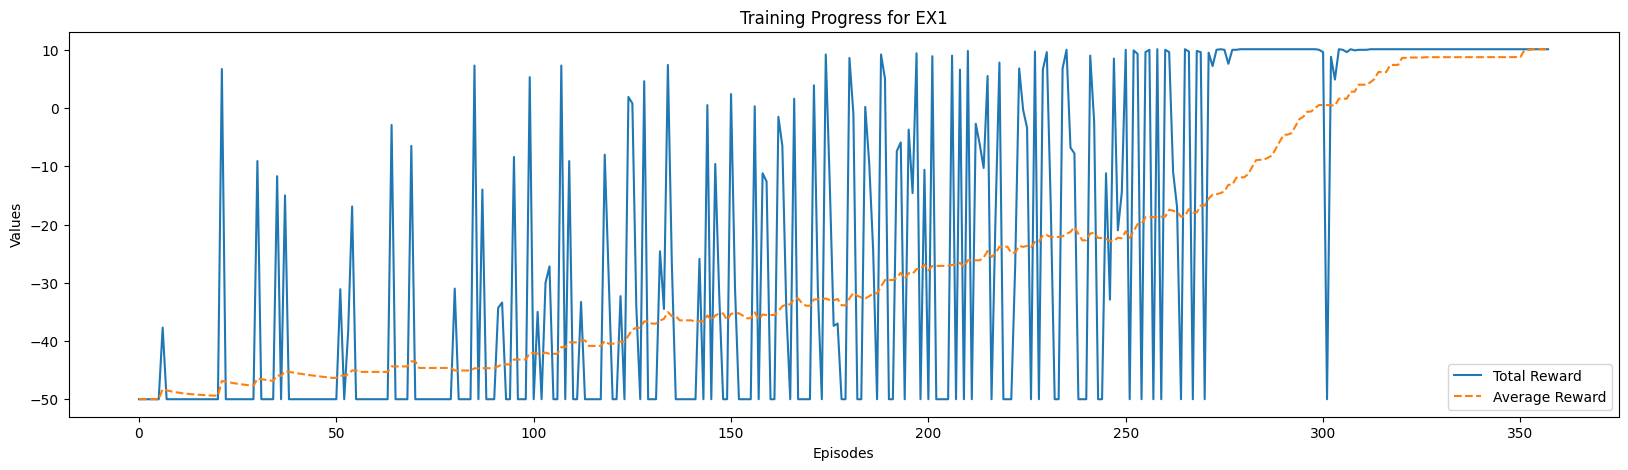

In [ ]:
plt.figure(figsize=(20, 5))
plt.plot(rewards_ex1, label='Total Reward')
plt.plot(avg_rewards_ex1, label='Average Reward', linestyle='--')
plt.xlabel('Episodes')
plt.ylabel('Values')
plt.title('Training Progress for EX1')
plt.legend()
plt.show()

### EX1 - Video test

Recording the video for EX1

In [ ]:
def record_video(env, agent, filename, steps=500):
    """
    Record a video of the agent's performance in the environment.

    Parameters:
    env (gym.Env): The environment in which the agent will be recorded.
    agent (DoubleQLearningAgent): The agent to be recorded.
    filename (str): The name of the output video file.
    steps (int): The maximum number of steps to record.

    Returns:
    HTML: An embedded video player for the recorded video.
    """
    # Seed the environment for reproducibility
    random.seed(2)
    env = PushAndPullSokobanEnv(dim_room=(7, 7), num_boxes=1, max_steps=500)
    state = convert_observation_to_state(env.room_state.copy())
    done = False
    iter = 0

    # Create a video writer
    with imageio.get_writer(filename, fps=5) as video:
        # Append the initial frame to the video
        video.append_data(env.render(mode='rgb_array'))
        while not done and iter < steps:
            # Choose an action based on the current state
            action = agent.choose_action(state)
            # Perform the action in the environment
            state, _, done, _ = env.step(action)
            state = convert_observation_to_state(state)
            # Append the new frame to the video
            video.append_data(env.render(mode='rgb_array'))
            iter += 1

    # Return an embedded video player for the recorded video
    return embed_mp4(filename)

Video for EX1

In [ ]:
video_filename_ex1 = 'sokoban_ex1.mp4'
record_video(sok, agent_ex1, video_filename_ex1)

/usr/local/lib/python3.10/dist-packages/imageio/plugins/ffmpeg.py:727: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  self._proc.stdin.write(im.tostring())


## EX2 - PUSH & PULL - ONE BOX

#### First experiment

DQN Agent Class

In [ ]:
class DQNAgent:
    def __init__(self, state_size, action_size, learning_rate=0.001):
        """
        Initialize the DQNAgent with the given state and action sizes and learning rate.

        Parameters:
        state_size (tuple): The shape of the state space.
        action_size (int): The number of possible actions.
        learning_rate (float): The learning rate for the neural network.
        """
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)  # Replay memory to store experiences
        self.gamma = 0.9  # Discount rate for future rewards
        self.epsilon = 1.0  # Initial exploration rate
        self.epsilon_min = 0.3  # Minimum exploration rate
        self.epsilon_decay = 0.995  # Decay rate for exploration
        self.learning_rate = learning_rate  # Learning rate for the neural network
        self.model = self._build_model()  # Build the main model
        self.target_model = self._build_model()  # Build the target model
        self.update_target_model()  # Initialize the target model weights

    def _build_model(self):
        """
        Build the neural network model for the agent.

        Returns:
        model (keras.Model): The compiled neural network model.
        """
        model = Sequential()
        model.add(Conv2D(32, (16,16), strides=(16,16), input_shape=self.state_size, activation='relu'))
        model.add(Conv2D(64, (3,3), activation='relu'))
        model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
        model.add(Flatten())
        model.add(Dense(512, activation='relu'))
        model.add(Dense(128, activation='relu'))
        model.add(Dense(32, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer="adam")
        return model

    def update_target_model(self):
        """
        Update the target model's weights to match the main model's weights.
        """
        self.target_model.set_weights(self.model.get_weights())

    def remember(self, state, action, reward, next_state, done):
        """
        Store a transition in the replay memory.

        Parameters:
        state (np.ndarray): The current state.
        action (int): The action taken.
        reward (float): The reward received.
        next_state (np.ndarray): The next state.
        done (bool): Whether the episode has ended.
        """
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        """
        Choose an action based on the current state.

        Parameters:
        state (np.ndarray): The current state.

        Returns:
        action (int): The action chosen by the agent.
        """
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)  # Explore: choose a random action
        act_values = self.model.predict(state, verbose=0)  # Predict action values
        return np.argmax(act_values[0])  # Exploit: choose the action with the highest value

    def replay(self, batch_size):
        """
        Train the model using a batch of experiences from the replay memory.

        Parameters:
        batch_size (int): The number of experiences to sample from the memory.
        """
        minibatch = random.sample(self.memory, batch_size)  # Sample a minibatch of experiences
        for state, action, reward, next_state, done in minibatch:
            target = self.model.predict(state, verbose=0)  # Predict the target Q-value
            if done:
                target[0][action] = reward  # If done, the target is the reward itself
            else:
                t = self.target_model.predict(next_state, verbose=0)[0]
                target[0][action] = reward + self.gamma * np.amax(t)  # Update target with discounted future reward
            self.model.fit(state, target, epochs=1, verbose=0)  # Train the model
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay  # Decay the exploration rate

    def load(self, name):
        """
        Load the model weights from a file.

        Parameters:
        name (str): The filename of the saved weights.
        """
        self.model.load_weights(name)

    def save(self, name):
        """
        Save the model weights to a file.

        Parameters:
        name (str): The filename to save the weights to.
        """
        self.model.save_weights(name)

Converting observation to state

In [ ]:
def convert_observation_to_state(observation):
    """
    Convert an observation to a state representation.

    Parameters:
    observation (np.ndarray): The observation to convert.

    Returns:
    observation (np.ndarray): The same observation, acting as the state representation.
    """
    return observation

Training function with batch processing and selective updating

In [ ]:
def train_dqn_agent(env, agent, episodes=1000, batch_size=64, success_threshold=-50):
    """
    Train a DQN agent in the specified environment.

    Parameters:
    env (gym.Env): The environment in which the agent will be trained.
    agent (DQNAgent): The DQN agent to be trained.
    episodes (int): The maximum number of episodes to train the agent.
    batch_size (int): The batch size for experience replay.
    success_threshold (float): The reward threshold to consider an episode successful.

    Returns:
    rewards (list): List of total rewards for each episode.
    avg_rewards (list): List of average rewards over recent episodes.
    """
    rewards = []
    avg_rewards = []
    recent_rewards = deque(maxlen=100)  # Track recent rewards for computing averages
    added_to_model = 0  # Counter for episodes where experiences are added to the model

    while added_to_model < 1000:  # Continue until 1000 successful episodes
        start_time = time.time()  # Record the start time of the episode
        state = convert_observation_to_state(env.reset())  # Reset the environment and convert the initial state
        state = np.reshape(state, [1] + list(agent.state_size))  # Reshape state to match input shape
        total_reward = 0
        done = False
        step_count = 0
        local_memory = []  # Temporarily store experiences for this episode

        while not done:
            action = agent.act(state)  # Choose an action based on the current state
            next_state, reward, done, _ = env.step(action)  # Perform the action in the environment
            next_state = convert_observation_to_state(next_state)  # Convert the next state
            next_state = np.reshape(next_state, [1] + list(agent.state_size))  # Reshape next_state to match input shape

            # Store the experience in local memory
            local_memory.append((state, action, reward, next_state, done))
            state = next_state
            total_reward += reward
            step_count += 1

        # Only update model and add experiences to replay memory if the episode is successful
        if total_reward >= success_threshold:
            added_to_model += 1
            for experience in local_memory:
                agent.remember(*experience)  # Add experiences to the agent's memory

            # Update the model using experiences from memory if enough experiences are available
            if len(agent.memory) > batch_size:
                agent.replay(batch_size)
                agent.update_target_model()

        rewards.append(total_reward)  # Record the total reward for this episode
        recent_rewards.append(total_reward)  # Append to recent rewards
        avg_recent_reward = np.mean(recent_rewards) if recent_rewards else 0  # Calculate average of recent rewards
        std_recent_reward = np.std(recent_rewards) if recent_rewards else 0  # Calculate standard deviation of recent rewards
        avg_rewards.append(avg_recent_reward)

        elapsed_time = time.time() - start_time  # Calculate elapsed time for this episode
        if total_reward >= success_threshold:
            print(f"Episode {added_to_model}/{episodes} - Reward: {total_reward}, Avg Reward: {avg_recent_reward}, Std Dev: {std_recent_reward}, Steps: {step_count}, Time: {elapsed_time:.2f}s")

    return rewards, avg_rewards

In [ ]:
#=============== DO NOT DELETE ===============
sok_2 = PushAndPullSokobanEnv(dim_room=(7, 7),num_boxes=1 ,max_steps=500)
# ============================================

Observation space: Box(0.0, 255.0, (112, 112, 3), float32)
Action space: Discrete(13)
Player position:[4 4]
Box location: (3, 4)


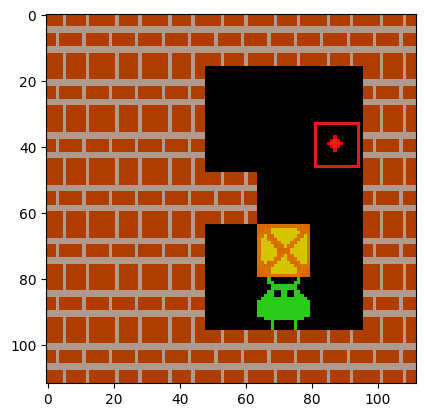

In [ ]:
screen = sok_2.render(mode='rgb_array')
plt.imshow(sok_2.render('rgb_array'))
observation, reward, done, _ = sok_2.step(1)
print_env_det(sok_2)

Training the DQN Agent for EX2

In [ ]:
# Get the shape of the observation space and the number of actions in the environment
state_size = sok_2.observation_space.shape  # Shape of the state space (e.g., (height, width, channels))
action_size = sok_2.action_space.n  # Number of possible actions in the environment

# Create an instance of the DQNAgent with the state and action sizes from the environment
agent_ex2 = DQNAgent(state_size, action_size)

# Train the DQN agent in the sok_2 environment
# rewards_ex2 will store the total rewards for each episode
# avg_rewards_ex2 will store the average rewards over recent episodes
rewards_ex2, avg_rewards_ex2 = train_dqn_agent(sok_2, agent_ex2)

Episode 1/1000 - Reward: -4.499999999999961, Avg Reward: -4.499999999999961, Std Dev: 0.0, Steps: 155, Time: 16.55s
Episode 2/1000 - Reward: 9.4, Avg Reward: 2.4500000000000197, Std Dev: 6.949999999999981, Steps: 16, Time: 11.07s
Episode 3/1000 - Reward: -50.00000000000044, Avg Reward: -15.033333333333466, Std Dev: 25.368002592943068, Steps: 500, Time: 1.24s
Episode 4/1000 - Reward: -50.00000000000044, Avg Reward: -23.77500000000021, Std Dev: 26.681489369973555, Steps: 500, Time: 1.38s
Episode 5/1000 - Reward: -50.00000000000044, Avg Reward: -29.020000000000255, Std Dev: 26.068402329256998, Steps: 500, Time: 1.38s
Episode 6/1000 - Reward: -3.9999999999999627, Avg Reward: -24.850000000000207, Std Dev: 25.558674326602798, Steps: 150, Time: 13.79s
Episode 7/1000 - Reward: -6.599999999999978, Avg Reward: -22.242857142857314, Std Dev: 24.509348487165408, Steps: 176, Time: 13.32s
Episode 8/1000 - Reward: 7.399999999999999, Avg Reward: -18.537500000000154, Std Dev: 24.93446096770513, Steps: 3

Plotting the Training Progress for EX2

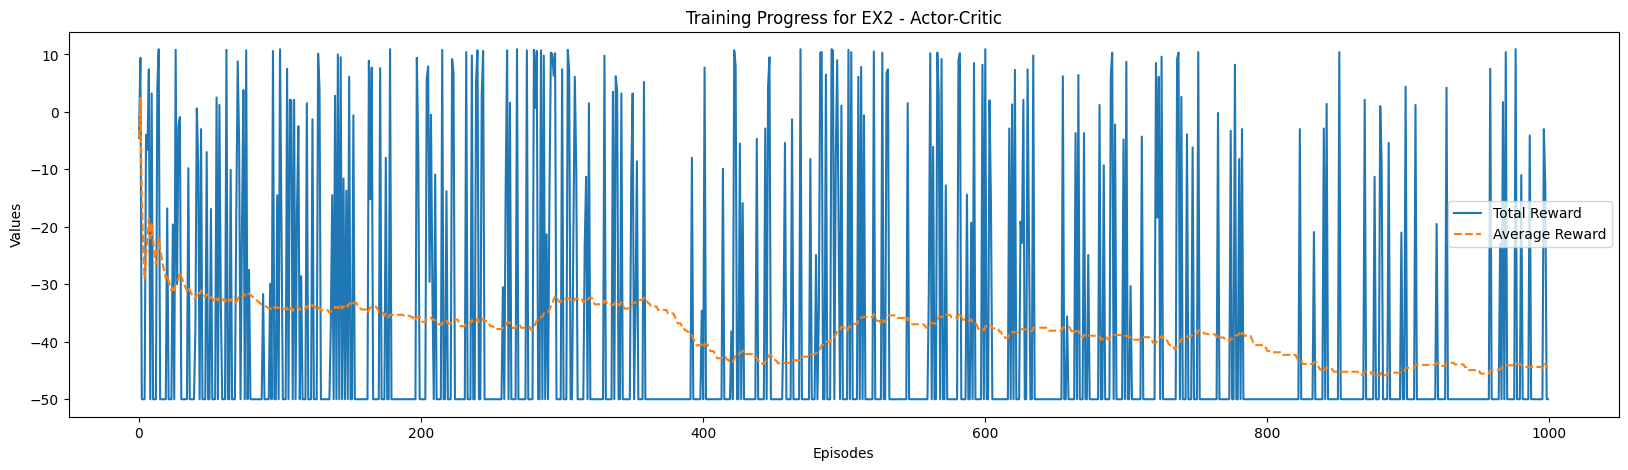

In [ ]:
plt.figure(figsize=(20, 5))
plt.plot(rewards_ex2, label='Total Reward')
plt.plot(avg_rewards_ex2, label='Average Reward', linestyle='--')
plt.xlabel('Episodes')
plt.ylabel('Values')
plt.title('Training Progress for EX2 - Actor-Critic')
plt.legend()
plt.show()

Recording and Displaying the Video for EX2

In [ ]:
def record_video(env, agent, filename, steps=500):
    """
    Record a video of the agent's performance in the environment and save it to a file.

    Parameters:
    env (gym.Env): The environment in which the agent will be recorded.
    agent (DQNAgent): The agent to be recorded.
    filename (str): The name of the output video file.
    steps (int): The maximum number of steps to record.

    Returns:
    HTML: An embedded video player for the recorded video.
    """
    # Reset the environment and convert the initial state
    state = convert_observation_to_state(env.reset())
    state = np.reshape(state, [1] + list(agent.state_size))  # Reshape state to match input shape
    done = False

    # Create a video writer to save the recorded video
    with imageio.get_writer(filename, fps=10) as video:
        for _ in range(steps):
            if done:
                break  # Exit loop if the episode is done

            # Choose an action based on the current state
            action = agent.act(state)
            # Perform the action in the environment
            next_state, reward, done, _ = env.step(action)
            # Convert and reshape the next state
            next_state = convert_observation_to_state(next_state)
            next_state = np.reshape(next_state, [1] + list(agent.state_size))
            # Append the current frame to the video
            video.append_data(env.render(mode='rgb_array'))
            state = next_state  # Update state for the next step

    # Return an embedded video player for the recorded video
    return embed_mp4(filename)

# Define the filename for the output video
video_filename = 'sokoban_ex2.mp4'

# Record a video of the agent's performance in the sok_2 environment
record_video(sok_2, agent_ex2, video_filename)

# Embed the recorded video in the notebook
embed_mp4(video_filename)

#### Second experiment

Training function for EX2

In [ ]:
def train_dqn_agent(env, agent, episodes=1000, batch_size=8, success_threshold=-2):
    """
    Train a DQN agent in the specified environment.

    Parameters:
    env (gym.Env): The environment in which the agent will be trained.
    agent (DQNAgent): The DQN agent to be trained.
    episodes (int): The total number of episodes to train the agent.
    batch_size (int): The batch size for experience replay.
    success_threshold (float): The reward threshold to consider an episode successful.

    Returns:
    rewards (list): List of total rewards for each episode.
    avg_rewards (list): List of average rewards over recent episodes.
    """
    rewards = []
    avg_rewards = []
    recent_rewards = deque(maxlen=100)  # Store recent rewards to calculate average and std deviation

    for e in range(episodes):
        start_time = time.time()  # Start timing the episode
        state = convert_observation_to_state(env.reset())  # Reset the environment and convert the state
        state = np.reshape(state, [1] + list(agent.state_size))  # Reshape state to match input shape
        total_reward = 0
        done = False
        step_count = 0

        while not done:
            action = agent.act(state)  # Choose an action based on the current state
            next_state, reward, done, _ = env.step(action)  # Perform the action and get the result
            next_state = convert_observation_to_state(next_state)  # Convert the next state
            next_state = np.reshape(next_state, [1] + list(agent.state_size))  # Reshape next_state to match input shape

            # Store the experience in the agent's memory
            agent.remember(state, action, reward, next_state, done)
            state = next_state  # Update state for the next step
            total_reward += reward  # Accumulate the total reward for this episode
            step_count += 1  # Count the number of steps taken

        # Update the model and add experiences to replay memory every 10 episodes
        if (e + 1) % 10 == 0:
            if len(agent.memory) > batch_size:  # Ensure there are enough experiences to sample
                agent.replay(batch_size)  # Perform experience replay
                agent.update_target_model()  # Update the target model

        # Record the rewards and calculate averages
        rewards.append(total_reward)
        recent_rewards.append(total_reward)
        avg_recent_reward = np.mean(recent_rewards) if recent_rewards else 0  # Calculate average of recent rewards
        std_recent_reward = np.std(recent_rewards) if recent_rewards else 0  # Calculate standard deviation of recent rewards
        avg_rewards.append(avg_recent_reward)

        elapsed_time = time.time() - start_time  # Calculate the time taken for the episode
        if (e + 1) % 10 == 0:
            # Print the results every 10 episodes
            print(f"Episode {e + 1}/{episodes} - Reward: {total_reward}, Avg Reward: {avg_recent_reward}, Std Dev: {std_recent_reward}, Steps: {step_count}, Time: {elapsed_time:.2f}s")

    return rewards, avg_rewards

Training the DQN Agent for EX2

In [ ]:
# Create an instance of the PushAndPullSokobanEnv environment with specific parameters
sok_2 = PushAndPullSokobanEnv(dim_room=(7, 7), num_boxes=1, max_steps=20)
# Get the shape of the observation space and the number of actions in the environment
state_size = sok_2.observation_space.shape  # Shape of the state space (e.g., (height, width, channels))
action_size = sok_2.action_space.n  # Number of possible actions in the environment

# Initialize a DQNAgent with the state and action sizes from the environment
agent_ex2 = DQNAgent(state_size, action_size)

# Train the DQN agent in the sok_2 environment
# - episodes: Total number of episodes to train the agent
# - batch_size: Number of experiences to sample from memory for training
# - success_threshold: Reward threshold to consider an episode as successful for adding experiences to the model
rewards_ex2, avg_rewards_ex2 = train_dqn_agent(sok_2, agent_ex2, episodes=5000, batch_size=8, success_threshold=-2)

Episode 10/5000 - Reward: -2.0000000000000004, Avg Reward: -2.0000000000000004, Std Dev: 0.0, Steps: 20, Time: 5.09s
Episode 20/5000 - Reward: -2.0000000000000004, Avg Reward: -2.0000000000000004, Std Dev: 0.0, Steps: 20, Time: 1.38s
Episode 30/5000 - Reward: -2.0000000000000004, Avg Reward: -2.0000000000000004, Std Dev: 0.0, Steps: 20, Time: 1.42s
Episode 40/5000 - Reward: -2.0000000000000004, Avg Reward: -1.6775000000000007, Std Dev: 2.0140118544834835, Steps: 20, Time: 1.41s
Episode 50/5000 - Reward: -2.0000000000000004, Avg Reward: -1.2440000000000004, Std Dev: 2.994138273360133, Steps: 20, Time: 1.35s
Episode 60/5000 - Reward: -2.0000000000000004, Avg Reward: -1.3700000000000003, Std Dev: 2.7477445296096947, Steps: 20, Time: 2.14s
Episode 70/5000 - Reward: -2.0000000000000004, Avg Reward: -1.118571428571429, Std Dev: 3.184439527144583, Steps: 20, Time: 1.39s
Episode 80/5000 - Reward: -2.0000000000000004, Avg Reward: -1.2287500000000002, Std Dev: 2.992999906030737, Steps: 20, Time:

Plotting the Training Progress

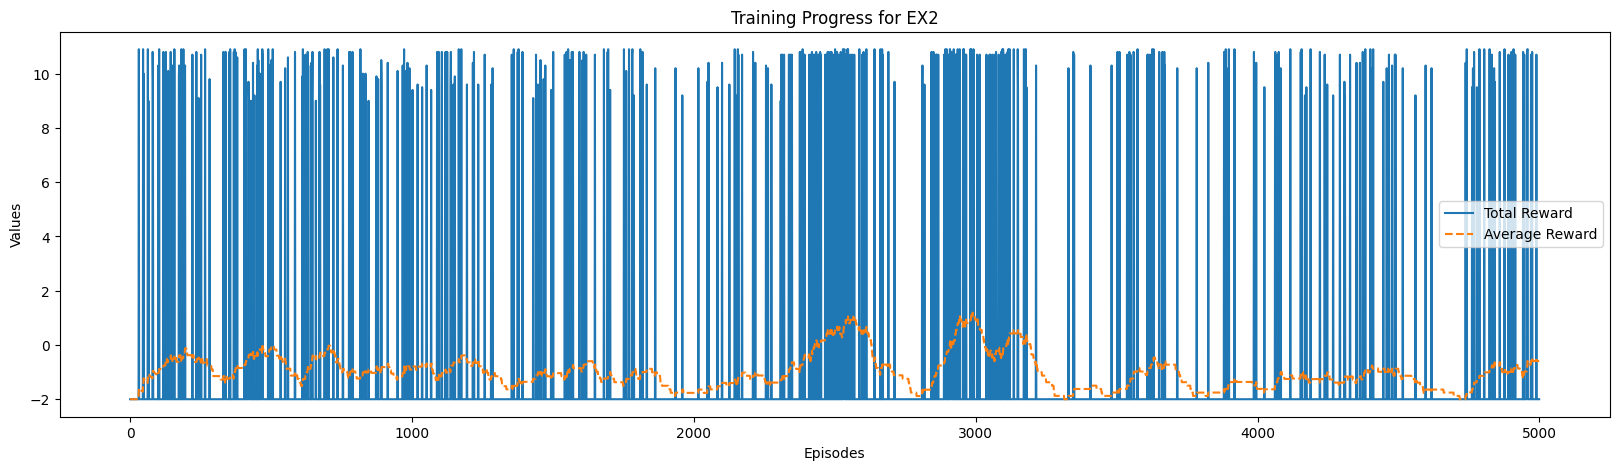

In [ ]:
plt.figure(figsize=(20, 5))
plt.plot(rewards_ex2, label='Total Reward')
plt.plot(avg_rewards_ex2, label='Average Reward', linestyle='--')
plt.xlabel('Episodes')
plt.ylabel('Values')
plt.title('Training Progress for EX2')
plt.legend()
plt.show()

#### Third experiment

Training function for EX2

In [ ]:
def train_dqn_agent(env, agent, episodes=1000, batch_size=8, success_threshold=-2):
    """
    Train a DQN agent in the specified environment.

    Parameters:
    env (gym.Env): The environment in which the agent will be trained.
    agent (DQNAgent): The DQN agent to be trained.
    episodes (int): The total number of episodes to train the agent.
    batch_size (int): The batch size for experience replay.
    success_threshold (float): The reward threshold to consider an episode successful for updating the model.

    Returns:
    rewards (list): List of total rewards for each episode.
    avg_rewards (list): List of average rewards over recent episodes.
    """
    rewards = []  # List to store the total reward of each episode
    avg_rewards = []  # List to store the average reward of recent episodes
    recent_rewards = deque(maxlen=100)  # Queue to keep track of recent rewards for calculating moving average

    for e in range(episodes):
        start_time = time.time()  # Start timing the episode
        state = convert_observation_to_state(env.reset())  # Reset the environment and get the initial state
        state = np.reshape(state, [1] + list(agent.state_size))  # Reshape state to match the input shape of the model
        total_reward = 0
        done = False
        step_count = 0

        while not done:
            action = agent.act(state)  # Choose an action based on the current state
            next_state, reward, done, _ = env.step(action)  # Perform the action and get the result
            next_state = convert_observation_to_state(next_state)  # Convert the next state
            next_state = np.reshape(next_state, [1] + list(agent.state_size))  # Reshape next_state to match input shape

            # Store the experience in the agent's memory
            agent.remember(state, action, reward, next_state, done)
            state = next_state  # Update state for the next step
            total_reward += reward  # Accumulate the total reward for this episode
            step_count += 1  # Count the number of steps taken

            if (step_count + 1) % 10 == 0:  # Update model and add experiences to replay memory every 10 steps
                if len(agent.memory) > batch_size:  # Ensure there are enough experiences to sample
                    agent.replay(batch_size)  # Perform experience replay
                    agent.update_target_model()  # Update the target model

        rewards.append(total_reward)  # Append the total reward for this episode
        recent_rewards.append(total_reward)  # Add the total reward to recent rewards
        avg_recent_reward = np.mean(recent_rewards) if recent_rewards else 0  # Calculate average of recent rewards
        std_recent_reward = np.std(recent_rewards) if recent_rewards else 0  # Calculate standard deviation of recent rewards
        avg_rewards.append(avg_recent_reward)  # Append the average recent reward to the list

        elapsed_time = time.time() - start_time  # Calculate the time taken for the episode
        if (e + 1) % 5 == 0:  # Print progress every 5 episodes
            print(f"Episode {e + 1}/{episodes} - Reward: {total_reward}, Avg Reward: {avg_recent_reward}, Std Dev: {std_recent_reward}, Steps: {step_count}, Time: {elapsed_time:.2f}s")

    return rewards, avg_rewards

Training the DQN Agent for EX2

In [ ]:
# Create an instance of the PushAndPullSokobanEnv environment with the specified parameters
sok_2 = PushAndPullSokobanEnv(dim_room=(7, 7), num_boxes=1, max_steps=20)

# Get the size of the state space and the number of possible actions in the environment
state_size = sok_2.observation_space.shape  # Shape of the observation space (e.g., (height, width, channels))
action_size = sok_2.action_space.n  # Number of possible actions

# Initialize a DQNAgent with the state size and action size obtained from the environment
agent_ex2 = DQNAgent(state_size, action_size)

# Train the DQN agent in the sok_2 environment
# - episodes: Number of episodes for training
# - batch_size: Size of the batches sampled from memory for experience replay
# - success_threshold: Reward threshold to determine if an episode is considered successful for adding experiences
rewards_ex2, avg_rewards_ex2 = train_dqn_agent(sok_2, agent_ex2, episodes=1000, batch_size=8, success_threshold=-2)

Episode 5/1000 - Reward: -2.0000000000000004, Avg Reward: -2.0000000000000004, Std Dev: 0.0, Steps: 20, Time: 2.81s
Episode 10/1000 - Reward: -2.0000000000000004, Avg Reward: -2.0000000000000004, Std Dev: 0.0, Steps: 20, Time: 2.86s
Episode 15/1000 - Reward: -2.0000000000000004, Avg Reward: -2.0000000000000004, Std Dev: 0.0, Steps: 20, Time: 3.99s
Episode 20/1000 - Reward: -2.0000000000000004, Avg Reward: -1.3700000000000003, Std Dev: 2.7461063344306242, Steps: 20, Time: 3.30s
Episode 25/1000 - Reward: -2.0000000000000004, Avg Reward: -1.0440000000000005, Std Dev: 3.2471624535892873, Steps: 20, Time: 3.21s
Episode 30/1000 - Reward: -2.0000000000000004, Avg Reward: -1.2033333333333338, Std Dev: 2.9855745771217226, Steps: 20, Time: 4.06s
Episode 35/1000 - Reward: -2.0000000000000004, Avg Reward: -0.6285714285714288, Std Dev: 3.823354654792899, Steps: 20, Time: 4.00s
Episode 40/1000 - Reward: -2.0000000000000004, Avg Reward: -0.8000000000000004, Std Dev: 3.6050658801192528, Steps: 20, Tim

Plotting the Training Progress

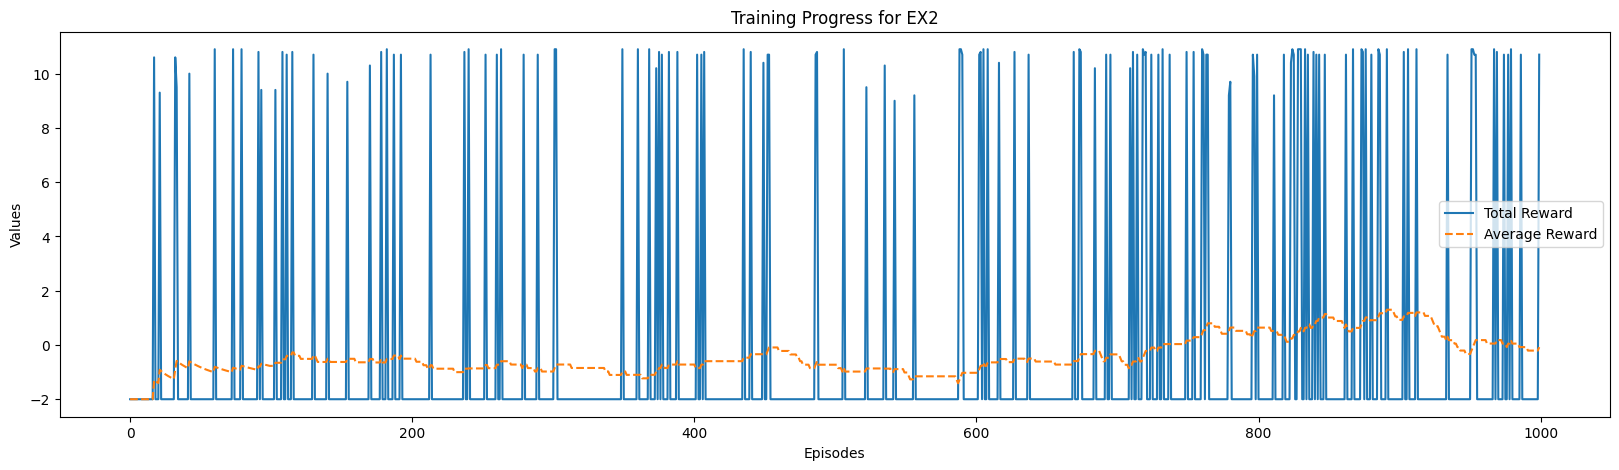

In [ ]:
plt.figure(figsize=(20, 5))
plt.plot(rewards_ex2, label='Total Reward')
plt.plot(avg_rewards_ex2, label='Average Reward', linestyle='--')
plt.xlabel('Episodes')
plt.ylabel('Values')
plt.title('Training Progress for EX2')
plt.legend()
plt.show()

#### Fourth experiment – DQN With Prioritized Replay Buffer

Prioritized Replay Buffer

In [ ]:
class PrioritizedReplayBuffer:
    def __init__(self, capacity, alpha=0.6):
        # Initialize the buffer with a maximum capacity and priority exponent alpha
        self.capacity = capacity
        self.buffer = deque(maxlen=capacity)  # Buffer to store experiences
        self.priorities = deque(maxlen=capacity)  # Buffer to store priorities
        self.alpha = alpha  # Exponent for priority calculation

    def add(self, error, transition):
        # Add a new experience with its priority to the buffer
        priority = (np.abs(error) + 1e-5) ** self.alpha  # Calculate priority
        self.buffer.append(transition)
        self.priorities.append(priority)

    def sample(self, batch_size, beta=0.4):
        # Sample a batch of experiences from the buffer
        scaled_priorities = np.array(self.priorities)
        if len(scaled_priorities) == 0:
            return [], [], []  # Return empty lists if buffer is empty
        sample_probs = scaled_priorities / scaled_priorities.sum()  # Calculate sampling probabilities
        indices = np.random.choice(len(self.buffer), batch_size, p=sample_probs)  # Sample indices based on probabilities
        samples = [self.buffer[idx] for idx in indices]  # Retrieve samples from the buffer
        total = len(self.buffer)
        weights = (total * sample_probs[indices]) ** (-beta)  # Calculate importance-sampling weights
        weights /= weights.max()  # Normalize weights
        return samples, indices, weights

    def update_priorities(self, indices, errors):
        # Update priorities for sampled experiences based on new errors
        for idx, error in zip(indices, errors):
            self.priorities[idx] = (np.abs(error) + 1e-5) ** self.alpha

DQN Agent

In [ ]:
class DQNAgent:
    def __init__(self, state_size, action_size, learning_rate=0.001):
        # Initialize the DQN agent
        self.state_size = state_size
        self.action_size = action_size
        self.memory = PrioritizedReplayBuffer(capacity=2000)  # Experience replay buffer with priorities
        self.gamma = 0.9  # Discount rate for future rewards
        self.epsilon = 1.0  # Exploration rate
        self.epsilon_min = 0.3  # Minimum exploration rate
        self.epsilon_decay = 0.995  # Decay rate for exploration
        self.learning_rate = learning_rate
        self.model = self._build_model()  # Build the Q-network model
        self.target_model = self._build_model()  # Build the target Q-network model
        self.update_target_model()  # Initialize target model with weights from the model

    def _build_model(self):
        # Build the Q-network model
        model = Sequential()
        model.add(Conv2D(32, (16,16), strides=(16,16), input_shape=self.state_size, activation='relu'))
        model.add(Conv2D(64, (3,3), activation='relu'))
        model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
        model.add(Flatten())
        model.add(Dense(512, activation='relu'))
        model.add(Dense(128, activation='relu'))
        model.add(Dense(32, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer="adam")  # Compile model with mean squared error loss and Adam optimizer
        return model

    def update_target_model(self):
        # Update the target model with weights from the main model
        self.target_model.set_weights(self.model.get_weights())

    def remember(self, state, action, reward, next_state, done):
        # Store the experience in the replay buffer
        q_values = self.model.predict(state, verbose=0)[0]
        q_next_values = self.target_model.predict(next_state, verbose=0)[0]
        target = reward
        if not done:
            target += self.gamma * np.max(q_next_values)
        error = abs(target - q_values[action])
        self.memory.add(error, (state, action, reward, next_state, done))

    def act(self, state):
        # Choose an action based on the exploration-exploitation tradeoff
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)  # Random action for exploration
        act_values = self.model.predict(state, verbose=0)
        return np.argmax(act_values[0])  # Best action according to the Q-network

    def replay(self, batch_size, beta=0.4):
        # Train the model on a batch of experiences from the replay buffer
        if len(self.memory.buffer) < batch_size:
            return  # Not enough experiences to sample
        minibatch, indices, weights = self.memory.sample(batch_size, beta)  # Sample batch
        errors = []
        for i, (state, action, reward, next_state, done) in enumerate(minibatch):
            target = self.model.predict(state, verbose=0)[0]
            if done:
                target[action] = reward
            else:
                t = self.target_model.predict(next_state, verbose=0)[0]
                target[action] = reward + self.gamma * np.amax(t)
            error = abs(target[action] - self.model.predict(state, verbose=0)[0][action])
            errors.append(error)
            self.model.fit(state, target.reshape(-1, self.action_size), epochs=1, verbose=0, sample_weight=np.array([weights[i]]))
        self.memory.update_priorities(indices, errors)  # Update priorities in the replay buffer
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay  # Decay exploration rate

    def load(self, name):
        # Load model weights from file
        self.model.load_weights(name)

    def save(self, name):
        # Save model weights to file
        self.model.save_weights(name)

Converting observation to state

In [ ]:
def convert_observation_to_state(observation):
    # Convert the observation to a state suitable for the model
    # Convert to grayscale if the observation has color channels
    if observation.shape[-1] == 3:  # Check if the observation has color channels
        observation = cv2.cvtColor(observation, cv2.COLOR_RGB2GRAY)

    # Resize the observation to the desired shape
    desired_shape = (112, 112)
    observation = cv2.resize(observation, desired_shape)

    # Normalize the pixel values (0 to 1)
    observation = observation / 255.0

    # Reshape the observation to add batch and channel dimensions
    observation = np.expand_dims(observation, axis=-1)  # Add channel dimension
    observation = np.expand_dims(observation, axis=0)   # Add batch dimension

    return observation

Training function for EX2

In [ ]:
def train_dqn_agent(env, agent, episodes=1000, batch_size=8, success_threshold=-2):
    # Train the DQN agent on the environment
    rewards = []
    avg_rewards = []
    recent_rewards = deque(maxlen=100)

    for e in range(episodes):
        start_time = time.time()
        state = convert_observation_to_state(env.reset())  # Reset environment and convert initial state
        total_reward = 0
        done = False
        step_count = 0

        while not done:
            action = agent.act(state)  # Choose an action based on the current state
            next_state, reward, done, _ = env.step(action)  # Execute action and get next state and reward
            next_state = convert_observation_to_state(next_state)  # Convert next state to suitable format

            # Store the experience
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            step_count += 1

            if (step_count + 1) % 10 == 0:
                # Update model and replay memory periodically
                agent.replay(batch_size)

        # Update the target model every episode
        agent.update_target_model()

        # Track rewards and compute statistics
        rewards.append(total_reward)
        recent_rewards.append(total_reward)
        avg_recent_reward = np.mean(recent_rewards) if recent_rewards else 0
        std_recent_reward = np.std(recent_rewards) if recent_rewards else 0
        avg_rewards.append(avg_recent_reward)

        elapsed_time = time.time() - start_time
        if (e + 1) % 2 == 0:
            print(f"Episode {e + 1}/{episodes} - Reward: {total_reward}, Avg Reward: {avg_recent_reward}, Std Dev: {std_recent_reward}, Steps: {step_count}, Time: {elapsed_time:.2f}s")

    return rewards, avg_rewards

Training the DQN Agent for EX2

In [ ]:
# Environment and agent setup
sok_2 = PushAndPullSokobanEnv(dim_room=(7, 7), num_boxes=1, max_steps=20)  # Create environment
state_size = (112, 112, 1)  # State size (height, width, channels)
action_size = sok_2.action_space.n  # Number of possible actions
agent_ex2 = DQNAgent(state_size, action_size)  # Initialize DQN agent

# Train the agent
rewards_ex2, avg_rewards_ex2 = train_dqn_agent(sok_2, agent_ex2, episodes=1000, batch_size=8, success_threshold=-2)

Episode 2/1000 - Reward: -2.0000000000000004, Avg Reward: -2.0000000000000004, Std Dev: 0.0, Steps: 20, Time: 9.41s
Episode 4/1000 - Reward: -2.0000000000000004, Avg Reward: -2.0000000000000004, Std Dev: 0.0, Steps: 20, Time: 7.41s
Episode 6/1000 - Reward: 10.6, Avg Reward: 0.09999999999999964, Std Dev: 4.695742752749559, Steps: 4, Time: 0.54s
Episode 8/1000 - Reward: -2.0000000000000004, Avg Reward: -0.4250000000000004, Std Dev: 4.167058314926731, Steps: 20, Time: 7.10s
Episode 10/1000 - Reward: -2.0000000000000004, Avg Reward: 0.48999999999999966, Std Dev: 4.980451786735818, Steps: 20, Time: 7.58s
Episode 12/1000 - Reward: -2.0000000000000004, Avg Reward: 1.1499999999999997, Std Dev: 5.457334514211127, Steps: 20, Time: 6.78s
Episode 14/1000 - Reward: -2.0000000000000004, Avg Reward: 0.6999999999999998, Std Dev: 5.171349644228009, Steps: 20, Time: 6.84s
Episode 16/1000 - Reward: -2.0000000000000004, Avg Reward: 0.36249999999999977, Std Dev: 4.919079563292304, Steps: 20, Time: 9.69s
Ep

#### Fifth experiment – Dueling Double DQN With Prioritized Replay Buffer

Prioritized Replay Buffer

In [ ]:
class PrioritizedReplayBuffer:
    def __init__(self, capacity, alpha=0.6):
        # Initialize the replay buffer with specified capacity and priority exponent alpha
        self.capacity = capacity
        self.buffer = deque(maxlen=capacity)  # Buffer to store experience tuples
        self.priorities = deque(maxlen=capacity)  # Buffer to store priorities of experiences
        self.alpha = alpha  # Exponent for priority calculation

    def add(self, error, transition):
        # Add a new experience to the buffer with calculated priority
        priority = (np.abs(error) + 1e-5) ** self.alpha  # Compute priority with a small constant for stability
        self.buffer.append(transition)  # Add experience to buffer
        self.priorities.append(priority)  # Add priority to priority buffer

    def sample(self, batch_size, beta=0.4):
        # Sample a batch of experiences from the buffer
        scaled_priorities = np.array(self.priorities)  # Convert priorities to a numpy array
        if len(scaled_priorities) == 0:
            return [], [], []  # Return empty lists if buffer is empty
        sample_probs = scaled_priorities / scaled_priorities.sum()  # Calculate sampling probabilities
        indices = np.random.choice(len(self.buffer), batch_size, p=sample_probs)  # Sample indices based on probabilities
        samples = [self.buffer[idx] for idx in indices]  # Retrieve experiences based on sampled indices
        total = len(self.buffer)
        weights = (total * sample_probs[indices]) ** (-beta)  # Compute importance-sampling weights
        weights /= weights.max()  # Normalize weights
        return samples, indices, weights

    def update_priorities(self, indices, errors):
        # Update the priorities of experiences in the buffer based on new errors
        for idx, error in zip(indices, errors):
            self.priorities[idx] = (np.abs(error) + 1e-5) ** self.alpha  # Update priority with new error

Dueling DQN Architecture

In [ ]:
def build_dueling_dqn_model(input_shape, action_size):
    # Build a Dueling DQN model with separate streams for value and advantage
    inputs = Input(shape=input_shape)
    x = Conv2D(32, (8, 8), strides=(4, 4), activation='relu')(inputs)  # Convolutional layer
    x = Conv2D(64, (4, 4), strides=(2, 2), activation='relu')(x)  # Convolutional layer
    x = Conv2D(64, (3, 3), strides=(1, 1), activation='relu')(x)  # Convolutional layer
    x = Flatten()(x)  # Flatten layer to prepare for dense layers
    x = Dense(512, activation='relu')(x)  # Fully connected dense layer

    # Dueling streams
    value = Dense(1)(x)  # Value stream
    advantage = Dense(action_size)(x)  # Advantage stream

    # Combine value and advantage streams
    output = Lambda(lambda a: a[0] + (a[1] - K.mean(a[1], axis=1, keepdims=True)))([value, advantage])

    model = Model(inputs=inputs, outputs=output)  # Define the model
    model.compile(loss='mse', optimizer=Adam(lr=0.001))  # Compile the model with mean squared error loss and Adam optimizer
    return model

Double DQN Agent

In [ ]:
class DQNAgent:
    def __init__(self, state_size, action_size, learning_rate=0.001):
        # Initialize the DQN agent with the specified parameters
        self.state_size = state_size
        self.action_size = action_size
        self.memory = PrioritizedReplayBuffer(capacity=2000)  # Experience replay buffer with priorities
        self.gamma = 0.9  # Discount rate for future rewards
        self.epsilon = 1.0  # Exploration rate
        self.epsilon_min = 0.1  # Minimum exploration rate
        self.epsilon_decay = 0.995  # Decay rate for exploration
        self.learning_rate = learning_rate
        self.model = build_dueling_dqn_model(state_size, action_size)  # Build the Q-network model
        self.target_model = build_dueling_dqn_model(state_size, action_size)  # Build the target Q-network model
        self.update_target_model()  # Initialize target model with weights from the main model

    def update_target_model(self):
        # Copy weights from the model to the target model
        self.target_model.set_weights(self.model.get_weights())

    def remember(self, state, action, reward, next_state, done):
        # Store an experience in the replay buffer
        q_values = self.model.predict(state, verbose=0)[0]  # Get Q-values for the current state
        q_next_values = self.target_model.predict(next_state, verbose=0)[0]  # Get Q-values for the next state
        target = reward
        if not done:
            target += self.gamma * np.max(q_next_values)  # Compute target value
        error = abs(target - q_values[action])  # Compute TD error
        self.memory.add(error, (state, action, reward, next_state, done))  # Add experience to replay buffer

    def act(self, state):
        # Select an action based on the exploration-exploitation tradeoff
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)  # Return random action for exploration
        act_values = self.model.predict(state, verbose=0)  # Get Q-values for the current state
        return np.argmax(act_values[0])  # Return action with highest Q-value

    def replay(self, batch_size, beta=0.4):
        # Train the model on a batch of experiences from the replay buffer
        if len(self.memory.buffer) < batch_size:
            return  # Not enough experiences to sample
        minibatch, indices, weights = self.memory.sample(batch_size, beta)  # Sample batch
        errors = []
        for i, (state, action, reward, next_state, done) in enumerate(minibatch):
            target = self.model.predict(state, verbose=0)[0]  # Get Q-values for the current state
            if done:
                target[action] = reward  # Update target for terminal state
            else:
                t = self.target_model.predict(next_state, verbose=0)[0]  # Get Q-values for the next state
                target[action] = reward + self.gamma * np.amax(t)  # Update target for non-terminal state
            error = abs(target[action] - self.model.predict(state, verbose=0)[0][action])  # Compute TD error
            errors.append(error)
            self.model.fit(state, target.reshape(-1, self.action_size), epochs=1, verbose=0, sample_weight=np.array([weights[i]]))  # Train model
        self.memory.update_priorities(indices, errors)  # Update priorities in the replay buffer
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay  # Decay exploration rate

    def load(self, name):
        # Load model weights from file
        self.model.load_weights(name)

    def save(self, name):
        # Save model weights to file
        self.model.save_weights(name)

Converting observation to state

In [ ]:
def convert_observation_to_state(observation):
    # Convert the raw observation to a format suitable for the model
    # Convert to grayscale if the observation has color channels
    if observation.shape[-1] == 3:  # Check if the observation has color channels
        observation = cv2.cvtColor(observation, cv2.COLOR_RGB2GRAY)

    # Resize the observation to the desired shape
    desired_shape = (112, 112)
    observation = cv2.resize(observation, desired_shape)

    # Normalize the pixel values (0 to 1)
    observation = observation / 255.0

    # Reshape the observation to add batch and channel dimensions
    observation = np.expand_dims(observation, axis=-1)  # Add channel dimension
    observation = np.expand_dims(observation, axis=0)   # Add batch dimension

    return observation

Training function for EX2

In [ ]:
def train_dqn_agent(env, agent, episodes=1000, batch_size=8, success_threshold=-2):
    # Train the DQN agent on the environment
    rewards = []
    avg_rewards = []
    recent_rewards = deque(maxlen=100)  # Track recent rewards for smoothing

    for e in range(episodes):
        start_time = time.time()
        state = convert_observation_to_state(env.reset())  # Reset environment and convert initial state
        total_reward = 0
        done = False
        step_count = 0

        while not done:
            action = agent.act(state)  # Choose an action based on the current state
            next_state, reward, done, _ = env.step(action)  # Execute action and get next state and reward
            next_state = convert_observation_to_state(next_state)  # Convert next state to suitable format

            # Store the experience
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            step_count += 1

            if step_count % 10 == 0:
                # Update model and replay memory periodically
                agent.replay(batch_size)

        # Update the target model every episode
        agent.update_target_model()

        rewards.append(total_reward)
        recent_rewards.append(total_reward)
        avg_recent_reward = np.mean(recent_rewards) if recent_rewards else 0
        std_recent_reward = np.std(recent_rewards) if recent_rewards else 0
        avg_rewards.append(avg_recent_reward)

        elapsed_time = time.time() - start_time
        if (e + 1) % 2 == 0:
            print(f"Episode {e + 1}/{episodes} - Reward: {total_reward}, Avg Reward: {avg_recent_reward}, Std Dev: {std_recent_reward}, Steps: {step_count}, Time: {elapsed_time:.2f}s")

    return rewards, avg_rewards

Training the DQN Agent for EX2

In [ ]:
# Environment and agent setup
sok_2 = PushAndPullSokobanEnv(dim_room=(7, 7), num_boxes=1, max_steps=20)  # Initialize the environment
state_size = (112, 112, 1)  # Define state size
action_size = sok_2.action_space.n  # Define number of actions
agent_ex2 = DQNAgent(state_size, action_size)  # Initialize the DQN agent

# Train the agent
rewards_ex2, avg_rewards_ex2 = train_dqn_agent(sok_2, agent_ex2, episodes=1000, batch_size=8, success_threshold=-2)

Episode 2/1000 - Reward: -2.0000000000000004, Avg Reward: -2.0000000000000004, Std Dev: 0.0, Steps: 20, Time: 8.98s
Episode 4/1000 - Reward: -2.0000000000000004, Avg Reward: -2.0000000000000004, Std Dev: 0.0, Steps: 20, Time: 7.34s
Episode 6/1000 - Reward: -2.0000000000000004, Avg Reward: -2.0000000000000004, Std Dev: 0.0, Steps: 20, Time: 7.02s
Episode 8/1000 - Reward: -2.0000000000000004, Avg Reward: -2.0000000000000004, Std Dev: 0.0, Steps: 20, Time: 6.95s
Episode 10/1000 - Reward: -2.0000000000000004, Avg Reward: -2.0000000000000004, Std Dev: 0.0, Steps: 20, Time: 6.02s
Episode 12/1000 - Reward: -2.0000000000000004, Avg Reward: -0.9666666666666669, Std Dev: 3.4271789500339134, Steps: 20, Time: 7.14s
Episode 14/1000 - Reward: -2.0000000000000004, Avg Reward: -1.1142857142857145, Std Dev: 3.1934882725538194, Steps: 20, Time: 7.26s
Episode 16/1000 - Reward: 10.3, Avg Reward: -0.45625000000000027, Std Dev: 4.08441684179027, Steps: 7, Time: 1.21s
Episode 18/1000 - Reward: 9.5, Avg Rewar

Plotting the Training Progress

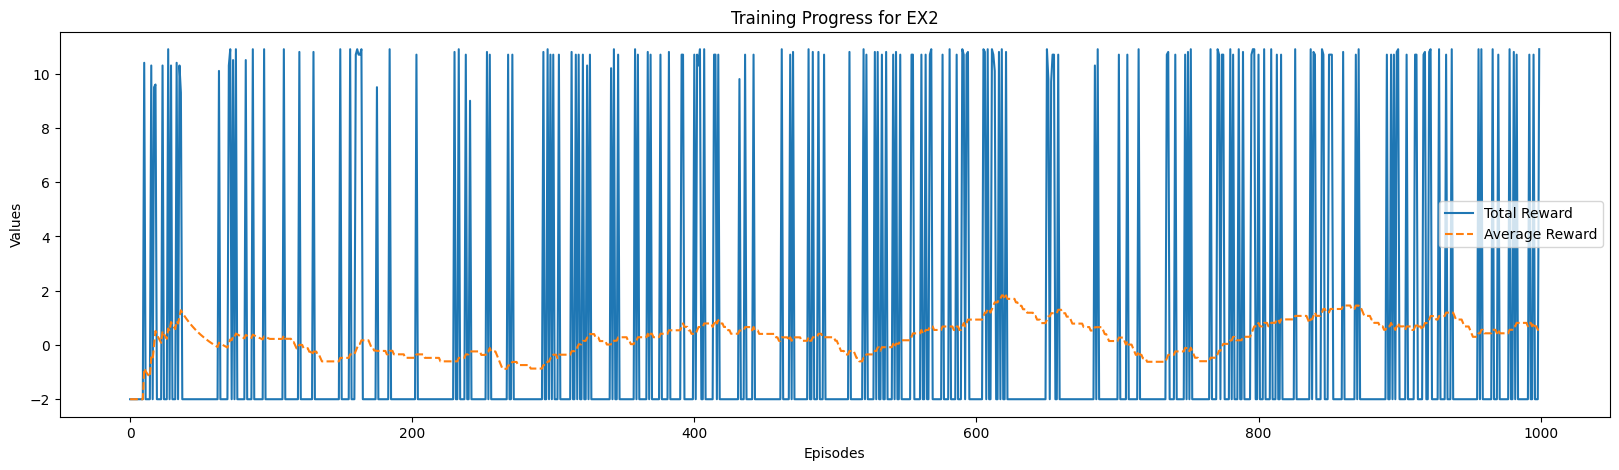

In [ ]:
plt.figure(figsize=(20, 5))
plt.plot(rewards_ex2, label='Total Reward')
plt.plot(avg_rewards_ex2, label='Average Reward', linestyle='--')
plt.xlabel('Episodes')
plt.ylabel('Values')
plt.title('Training Progress for EX2')
plt.legend()
plt.show()

### EX2 - Video test

Recording and Displaying the Video for EX2

In [ ]:
def record_video(env, agent, filename, steps=500):
    # Initialize the environment and agent for recording
    state = convert_observation_to_state(env.reset())  # Reset the environment and convert the initial state
    state = np.reshape(state, [1] + list(agent.state_size))  # Reshape the state to match model input
    done = False

    # Create a video writer object with a specified frame rate (fps)
    with imageio.get_writer(filename, fps=5) as video:
        for _ in range(steps):
            if done:
                break  # Exit loop if the episode ends
            action = agent.act(state)  # Select an action based on the current state
            next_state, reward, done, _ = env.step(action)  # Execute action and get next state, reward, and done flag
            next_state = convert_observation_to_state(next_state)  # Convert the next state to the desired format
            next_state = np.reshape(next_state, [1] + list(agent.state_size))  # Reshape the next state
            video.append_data(env.render(mode='rgb_array'))  # Capture the current frame and add to the video
            state = next_state  # Update the state for the next step

    # Return the embedded video
    return embed_mp4(filename)

video_filename = 'sokoban_ex2.mp4'  # File name for the recorded video
record_video(sok_2, agent_ex2, video_filename)  # Record a video of the agent playing in the environment
embed_mp4(video_filename)  # Embed the recorded video

Video for EX2

In [ ]:
video_filename = 'sokoban_ex2.mp4'  # File name for the recorded video
record_video(sok_2, agent_ex2, video_filename)  # Record a video of the agent playing in the environment
embed_mp4(video_filename)  # Embed the recorded video

Video for EX2

In [ ]:
video_filename = 'sokoban_ex2.mp4'  # File name for the recorded video
record_video(sok_2, agent_ex2, video_filename)  # Record a video of the agent playing in the environment
embed_mp4(video_filename)  # Embed the recorded video

Video for EX2

In [ ]:
video_filename = 'sokoban_ex2.mp4'  # File name for the recorded video
record_video(sok_2, agent_ex2, video_filename)  # Record a video of the agent playing in the environment
embed_mp4(video_filename)  # Embed the recorded video

#### Sixth experiment

Prioritized Replay Buffer

In [ ]:
class PrioritizedReplayBuffer:
    def __init__(self, capacity, alpha=0.6):
        """
        Initialize the Prioritized Replay Buffer

        Args:
        capacity (int): Maximum number of transitions to store in the buffer
        alpha (float): Priority exponent to control how much prioritization is used (0 - no prioritization, 1 - full prioritization)
        """
        self.capacity = capacity
        self.buffer = deque(maxlen=capacity)  # Store the transitions
        self.priorities = deque(maxlen=capacity)  # Store the priority values for each transition
        self.alpha = alpha  # Control the degree of prioritization

    def add(self, error, transition):
        """
        Add a transition to the buffer with its priority based on the given error

        Args:
        error (float): TD error of the transition, used to calculate its priority
        transition (tuple): The transition to store, typically (state, action, reward, next_state, done)
        """
        # Compute the priority based on the error and alpha
        priority = (np.abs(error) + 1e-5) ** self.alpha
        self.buffer.append(transition)  # Add transition to buffer
        self.priorities.append(priority)  # Add its priority to priorities list

    def sample(self, batch_size, beta=0.4):
        """
        Sample a batch of transitions from the buffer according to their priorities

        Args:
        batch_size (int): Number of transitions to sample
        beta (float): Importance-sampling exponent to correct for the bias introduced by prioritized sampling

        Returns:
        tuple: A tuple containing sampled transitions, their indices, and their importance-sampling weights
        """
        scaled_priorities = np.array(self.priorities)  # Convert priorities to a numpy array
        if len(scaled_priorities) == 0:
            return [], [], []  # If no priorities are available, return empty samples

        # Calculate sampling probabilities proportional to priorities
        sample_probs = scaled_priorities / scaled_priorities.sum()
        # Randomly sample indices based on probabilities.
        indices = np.random.choice(len(self.buffer), batch_size, p=sample_probs)
        # Retrieve the sampled transitions.
        samples = [self.buffer[idx] for idx in indices]

        total = len(self.buffer)  # Total number of transitions in buffer
        # Compute the importance-sampling weights
        weights = (total * sample_probs[indices]) ** (-beta)
        weights /= weights.max()  # Normalize weights

        return samples, indices, weights

    def update_priorities(self, indices, errors):
        """
        Update the priorities of the sampled transitions based on the new errors

        Args:
        indices (list of int): Indices of the sampled transitions
        errors (list of float): The new TD errors of the sampled transitions
        """
        for idx, error in zip(indices, errors):
            # Update the priority of each sampled transition
            self.priorities[idx] = (np.abs(error) + 1e-5) ** self.alpha

DQN Agent

In [ ]:
class DQNAgent:
    def __init__(self, state_size, action_size, learning_rate=0.001):
        """
        Initialize the DQN Agent

        Args:
        state_size (tuple): Shape of the input state
        action_size (int): Number of possible actions
        learning_rate (float): Learning rate for the optimizer
        """
        self.state_size = state_size
        self.action_size = action_size
        self.memory = PrioritizedReplayBuffer(capacity=2000)  # Initialize the prioritized replay buffer
        self.gamma = 0.9  # Discount factor for future rewards
        self.epsilon = 1.0  # Exploration rate (epsilon-greedy policy)
        self.epsilon_min = 0.1  # Minimum value for epsilon
        self.epsilon_decay = 0.995  # Decay rate for epsilon
        self.learning_rate = learning_rate  # Learning rate for the optimizer
        self.model = self.build_model()  # Build the main model
        self.target_model = self.build_model()  # Build the target model
        self.update_target_model()  # Initialize target model weights

    def build_model(self):
        """
        Build the neural network model

        Returns:
        Model: Compiled Keras model
        """
        # Define the input layer
        inputs = Input(shape=self.state_size)
        # Define convolutional layers
        conv1 = Conv2D(32, (8, 8), strides=(4, 4), activation='relu')(inputs)
        conv2 = Conv2D(64, (4, 4), strides=(2, 2), activation='relu')(conv1)
        conv3 = Conv2D(64, (3, 3), strides=(1, 1), activation='relu')(conv2)
        flatten = Flatten()(conv3)

        # Define dense layers
        tensor1 = Dense(512, activation='relu')(flatten)
        tensor2 = Dense(13, activation='relu')(flatten)

        # Define a custom lambda layer for concatenation
        def custom_lambda(x):
            return [x[0], x[1]]

        lambda_layer = Lambda(custom_lambda, output_shape=lambda s: [s[0], s[1]])([tensor1, tensor2])
        concat_layer = Concatenate()([tensor2, lambda_layer[0]])

        # Define the output layer
        outputs = Dense(self.action_size, activation='linear')(concat_layer)

        # Create and compile the model
        model = Model(inputs=inputs, outputs=outputs)
        model.compile(optimizer=Adam(learning_rate=self.learning_rate), loss='mse')
        return model

    def update_target_model(self):
        """
        Update the weights of the target model with the weights of the main model
        """
        self.target_model.set_weights(self.model.get_weights())

    def remember(self, state, action, reward, next_state, done):
        """
        Store a transition in the replay buffer and updates priorities

        Args:
        state (array): Current state
        action (int): Action taken
        reward (float): Reward received
        next_state (array): Next state after taking the action
        done (bool): Whether the episode has ended
        """
        # Predict Q-values for the current state and next state
        q_values = self.model.predict(state, verbose=0)[0]
        q_next_values = self.target_model.predict(next_state, verbose=0)[0]

        # Calculate the target Q-value
        target = reward
        if not done:
            target += self.gamma * np.max(q_next_values)

        # Compute the error and add it to the replay buffer
        error = abs(target - q_values[action])
        self.memory.add(error, (state, action, reward, next_state, done))

    def act(self, state):
        """
        Select an action based on the epsilon-greedy policy

        Args:
        state (array): Current state

        Returns:
        int: Action to be taken
        """
        # With probability epsilon, choose a random action (exploration)
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)

        # Otherwise, choose the action with the highest Q-value (exploitation)
        act_values = self.model.predict(state, verbose=0)
        return np.argmax(act_values[0])

    def replay(self, batch_size, beta=0.4):
        """
        Train the model using a batch of transitions from the replay buffer

        Args:
        batch_size (int): Number of transitions to sample from the replay buffer
        beta (float): Importance-sampling exponent
        """
        # If the buffer does not contain enough transitions, return
        if len(self.memory.buffer) < batch_size:
            return

        # Sample a minibatch from the replay buffer
        minibatch, indices, weights = self.memory.sample(batch_size, beta)
        errors = []

        # Update the model with each transition in the minibatch
        for i, (state, action, reward, next_state, done) in enumerate(minibatch):
            target = self.model.predict(state, verbose=0)[0]
            if done:
                target[action] = reward
            else:
                t = self.target_model.predict(next_state, verbose=0)[0]
                target[action] = reward + self.gamma * np.amax(t)

            # Compute the error and append it to the list of errors
            error = abs(target[action] - self.model.predict(state, verbose=0)[0][action])
            errors.append(error)

            # Perform a training step
            self.model.fit(state, target.reshape(-1, self.action_size), epochs=1, verbose=0, sample_weight=np.array([weights[i]]))

        # Update the priorities in the replay buffer
        self.memory.update_priorities(indices, errors)

        # Decay epsilon to reduce exploration over time
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def load(self, name):
        """
        Load the model weights from a file

        Args:
        name (str): Path to the file containing model weights
        """
        self.model.load_weights(name)

    def save(self, name):
        """
        Save the model weights to a file

        Args:
        name (str): Path to the file to save model weights
        """
        self.model.save_weights(name)

Converting observation to state



In [ ]:
def convert_observation_to_state(observation):
    """
    Convert an observation image into a state representation suitable for the model

    Args:
    observation (numpy.ndarray): Input image observation, which can be in RGB format

    Returns:
    numpy.ndarray: Processed image in the format (1, height, width, 1)
    """
    # Check if the observation has 3 channels (RGB). If so, convert it to grayscale
    if observation.shape[-1] == 3:
        observation = cv2.cvtColor(observation, cv2.COLOR_RGB2GRAY)

    # Define the desired shape for the observation
    desired_shape = (112, 112)

    # Resize the image to the desired shape
    observation = cv2.resize(observation, desired_shape)

    # Normalize pixel values to the range [0, 1]
    observation = observation / 255.0

    # Add a channel dimension to the image, resulting in shape (height, width, 1)
    observation = np.expand_dims(observation, axis=-1)

    # Add a batch dimension to the image, resulting in shape (1, height, width, 1)
    observation = np.expand_dims(observation, axis=0)

    return observation

Finding target location

In [ ]:
def find_target_location(env):
    """
    Find the location of the target (denoted by the value 2) in the environment's room state

    Args:
    env (object): The environment object which has a `room_state` attribute representing the state of the room

    Returns:
    tuple or None: The (row, column) coordinates of the target location if found, otherwise None
    """
    # Find the index of the maximum value in the `room_state` array that is equal to 2
    idx = np.argmax(env.room_state == 2)

    # Check if the value at the found index is indeed 2 (target)
    if env.room_state.flat[idx] == 2:
        # Convert the flat index to a 2D coordinate (row, column) and return it
        return np.unravel_index(idx, env.room_state.shape)

    # Return None if the target is not found
    return None

Calculating distance to target

In [ ]:
def calculate_distance_to_target(box_position, target_position):
    """
    Calculate the Euclidean distance between two points in a 2D space

    Args:
    box_position (tuple): The (x, y) coordinates of the box position
    target_position (tuple): The (x, y) coordinates of the target position

    Returns:
    float: The Euclidean distance between the box and the target
    """
    # Compute the squared differences between the x and y coordinates of the two positions
    x_diff = box_position[0] - target_position[0]
    y_diff = box_position[1] - target_position[1]

    # Calculate the Euclidean distance using the formula: sqrt((x_diff)^2 + (y_diff)^2)
    distance = np.sqrt(x_diff ** 2 + y_diff ** 2)

    return distance

Training function for EX2

In [ ]:
def train_dqn_agent(env, agent, episodes=1000, batch_size=8, success_threshold=-2):
    """
    Train a Deep Q-Network (DQN) agent in a given environment

    Args:
    env: The environment in which the agent will be trained
    agent: The DQN agent that will be trained
    episodes (int): Number of episodes to train the agent
    batch_size (int): Number of experiences to sample from the replay buffer for training
    success_threshold (float): The threshold for considering an episode as successful

    Returns:
    rewards (list): List of rewards obtained in each episode
    avg_rewards (list): List of average rewards over the last 100 episodes
    """
    rewards = []          # List to keep track of rewards for each episode
    avg_rewards = []      # List to keep track of average rewards over the last 100 episodes

    for episode in range(episodes):
        # Reset the environment and get the initial state
        state = convert_observation_to_state(env.reset())
        done = False
        total_reward = 0
        step_count = 0

        # Find the initial positions of the box and the target
        box_position = find_box_location(env)
        target_position = find_target_location(env)  # Get the target position
        if target_position is None:
            raise ValueError("Target position could not be found in the environment.")

        # Calculate the initial distance between the box and the target
        old_distance = calculate_distance_to_target(box_position, target_position)

        while not done:
            # Select an action using the agent's policy
            action = agent.act(state)

            # Take the selected action and observe the next state and reward
            next_state, reward, done, _ = env.step(action)
            next_state = convert_observation_to_state(next_state)

            # Store the experience in the replay buffer
            agent.remember(state, action, reward, next_state, done)

            # Update the state and accumulate the reward
            state = next_state
            total_reward += reward
            step_count += 1

            # Update the position of the box and calculate the distance to the target
            box_position = find_box_location(env)
            if box_position is not None:
                distance = calculate_distance_to_target(box_position, target_position)
                # If the agent is getting closer to the target, give a small positive reward
                if distance < old_distance:
                    total_reward += 0.1
                old_distance = distance

            # If the episode is done, record the reward and calculate the average reward
            if done:
                rewards.append(total_reward)
                avg_reward = np.mean(rewards[-100:])
                avg_rewards.append(avg_reward)
                print(f"Episode: {episode+1}/{episodes}, Reward: {total_reward}, Avg Reward: {avg_reward:.2f}, Steps: {step_count}")
                break

            # Train the agent with a batch of experiences every 10 steps
            if step_count % 10 == 0:
                agent.replay(batch_size)

    return rewards, avg_rewards

Training the DQN Agent for EX2

In [ ]:
# Environment and agent setup
sok_2 = PushAndPullSokobanEnv(dim_room=(7, 7), num_boxes=1, max_steps=20)  # Initialize the environment
state_size = (112, 112, 1)  # Define state size
action_size = sok_2.action_space.n  # Define number of actions
agent_ex2 = DQNAgent(state_size, action_size)  # Initialize the DQN agent

# Train the agent
rewards_ex2, avg_rewards_ex2 = train_dqn_agent(sok_2, agent_ex2, episodes=1000, batch_size=8, success_threshold=-2)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Episode: 1/1000, Reward: 9.3, Avg Reward: 9.30, Steps: 18
Episode: 2/1000, Reward: -2.0000000000000004, Avg Reward: 3.65, Steps: 20
Episode: 3/1000, Reward: -1.9000000000000006, Avg Reward: 1.80, Steps: 20
Episode: 4/1000, Reward: -2.0000000000000004, Avg Reward: 0.85, Steps: 20
Episode: 5/1000, Reward: -1.9000000000000006, Avg Reward: 0.30, Steps: 20
Episode: 6/1000, Reward: -2.0000000000000004, Avg Reward: -0.08, Steps: 20
Episode: 7/1000, Reward: -1.9000000000000006, Avg Reward: -0.34, Steps: 20
Episode: 8/1000, Reward: -1.9000000000000006, Avg Reward: -0.54, Steps: 20
Episode: 9/1000, Reward: -2.0000000000000004, Avg Reward: -0.70, Steps: 20
Episode: 10/1000, Reward: -1.8000000000000005, Avg Reward: -0.81, Steps: 20
Episode: 11/1000, Reward: -2.0000000000000004, Avg Reward: -0.92, Steps: 20
Episode: 12/1000, Reward: -1.8000000000000005, Avg Reward: -0.99, Steps: 20
Episode: 13/1000, Reward: -2.0000000000000004, Avg Reward: -1.07, Steps: 20
Episode: 14/1000, Reward: -1.9000000000000

Plotting the Training Progress

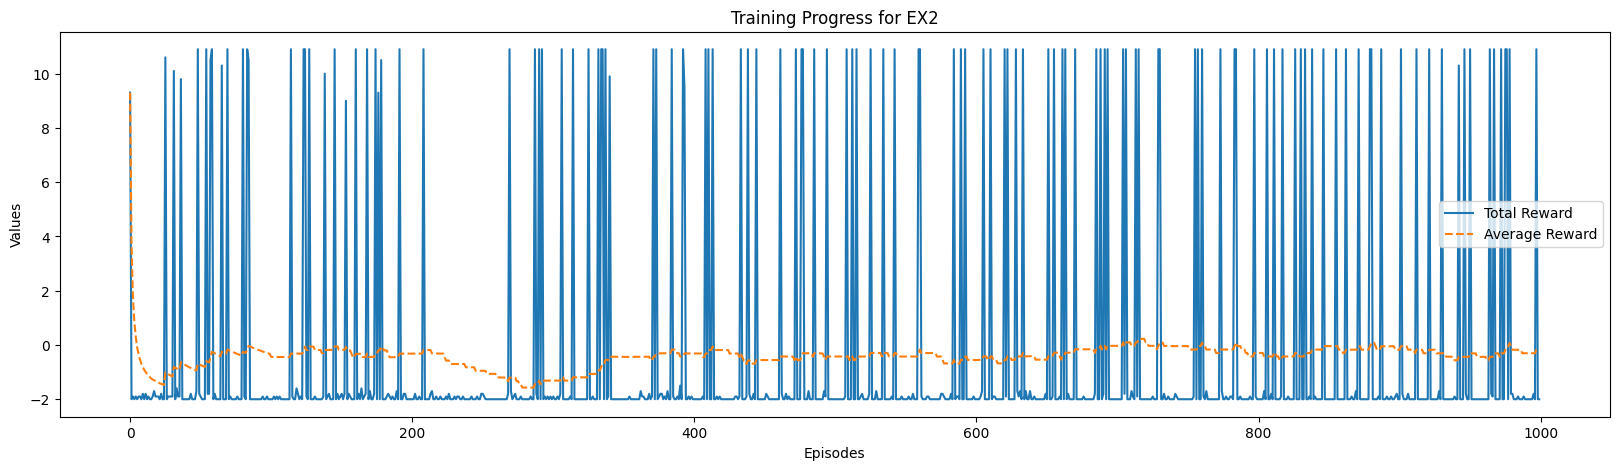

In [ ]:
plt.figure(figsize=(20, 5))
plt.plot(rewards_ex2, label='Total Reward')
plt.plot(avg_rewards_ex2, label='Average Reward', linestyle='--')
plt.xlabel('Episodes')
plt.ylabel('Values')
plt.title('Training Progress for EX2')
plt.legend()
plt.show()

#### Seventh experiment

Prioritized Replay Buffer

In [ ]:
class PrioritizedReplayBuffer:
    """
    A replay buffer with prioritized experience sampling for reinforcement learning

    Attributes:
    capacity (int): The maximum number of transitions the buffer can hold
    buffer (deque): A deque to store transitions
    priorities (deque): A deque to store priorities of transitions
    alpha (float): The exponent to control the impact of the priority

    Methods:
    add(error, transition): Adds a new transition with a given priority to the buffer
    sample(batch_size, beta=0.4): Samples a batch of transitions from the buffer based on their priorities
    update_priorities(indices, errors): Updates the priorities of transitions in the buffer
    """

    def __init__(self, capacity, alpha=0.6):
        """
        Initialize the PrioritizedReplayBuffer

        Args:
        capacity (int): The maximum size of the buffer
        alpha (float): The exponent used to calculate the priority
        """
        self.capacity = capacity
        self.buffer = deque(maxlen=capacity)  # Stores transitions
        self.priorities = deque(maxlen=capacity)  # Stores priorities of the transitions
        self.alpha = alpha  # Controls the impact of the priority on sampling

    def add(self, error, transition):
        """
        Add a new transition to the buffer with a computed priority

        Args:
        error (float): The absolute error for the transition
        transition (tuple): The transition to be added to the buffer
        """
        priority = (np.abs(error) + 1e-5) ** self.alpha  # Compute priority based on the error
        self.buffer.append(transition)  # Add transition to the buffer
        self.priorities.append(priority)  # Add computed priority to the priorities deque

    def sample(self, batch_size, beta=0.4):
        """
        Sample a batch of transitions from the buffer according to their priorities

        Args:
        batch_size (int): The number of transitions to sample
        beta (float): The importance-sampling weight exponent

        Returns:
        samples (list): A list of sampled transitions
        indices (list): Indices of the sampled transitions
        weights (np.array): Importance-sampling weights for the sampled transitions
        """
        scaled_priorities = np.array(self.priorities)  # Convert priorities to a NumPy array
        if len(scaled_priorities) == 0:
            return [], [], []  # Return empty lists if the buffer is empty

        sample_probs = scaled_priorities / scaled_priorities.sum()  # Calculate sampling probabilities
        indices = np.random.choice(len(self.buffer), batch_size, p=sample_probs)  # Sample indices based on probabilities
        samples = [self.buffer[idx] for idx in indices]  # Retrieve transitions using sampled indices
        total = len(self.buffer)
        weights = (total * sample_probs[indices]) ** (-beta)  # Compute importance-sampling weights
        weights /= weights.max()  # Normalize weights

        return samples, indices, weights

    def update_priorities(self, indices, errors):
        """
        Update the priorities of transitions in the buffer

        Args:
        indices (list): The indices of the transitions to update
        errors (list): The new errors for the transitions
        """
        for idx, error in zip(indices, errors):
            self.priorities[idx] = (np.abs(error) + 1e-5) ** self.alpha  # Update priority based on the new error

DQN Agent

In [ ]:
class DQNAgent:
    """
    Deep Q-Network (DQN) agent for reinforcement learning

    Attributes:
    state_size (tuple): The shape of the state space
    action_size (int): The number of possible actions
    memory (PrioritizedReplayBuffer): The replay buffer for storing transitions
    gamma (float): The discount factor for future rewards
    epsilon (float): The initial exploration rate
    epsilon_min (float): The minimum exploration rate
    epsilon_decay (float): The decay rate for epsilon
    learning_rate (float): The learning rate for the optimizer
    model (Model): The Q-network model
    target_model (Model): The target Q-network model
    """

    def __init__(self, state_size, action_size, learning_rate=0.001):
        """
        Initialize the DQN agent

        Args:
        state_size (tuple): The shape of the state space
        action_size (int): The number of possible actions
        learning_rate (float): The learning rate for the optimizer
        """
        self.state_size = state_size
        self.action_size = action_size
        self.memory = PrioritizedReplayBuffer(capacity=2000)  # Initialize the replay buffer
        self.gamma = 0.9  # Discount factor for future rewards
        self.epsilon = 1.0  # Initial exploration rate
        self.epsilon_min = 0.1  # Minimum exploration rate
        self.epsilon_decay = 0.995  # Decay rate for epsilon
        self.learning_rate = learning_rate
        self.model = self.build_model()  # Build the Q-network model
        self.target_model = self.build_model()  # Build the target Q-network model
        self.update_target_model()  # Initialize target model with the weights of the Q-network model

    def build_model(self):
        """
        Build and compiles the Q-network model

        Returns:
        model (Model): The compiled Q-network model
        """
        inputs = Input(shape=self.state_size)  # Input layer for the model
        # Convolutional layers to process input states
        conv1 = Conv2D(32, (8, 8), strides=(4, 4), activation='relu')(inputs)
        conv2 = Conv2D(64, (4, 4), strides=(2, 2), activation='relu')(conv1)
        conv3 = Conv2D(64, (3, 3), strides=(1, 1), activation='relu')(conv2)
        flatten = Flatten()(conv3)  # Flatten the output from convolutional layers

        # Dense layers for further processing
        tensor1 = Dense(512, activation='relu')(flatten)
        tensor2 = Dense(13, activation='relu')(flatten)  # Example tensor, adjust as necessary

        def custom_lambda(x):
            return [x[0], x[1]]  # Custom lambda function to process tensors

        # Lambda layer for custom processing of tensors
        lambda_layer = Lambda(custom_lambda, output_shape=lambda s: [s[0], s[1]])([tensor1, tensor2])
        concat_layer = Concatenate()([tensor2, lambda_layer[0]])  # Concatenate layers

        # Output layer to predict Q-values for each action
        outputs = Dense(self.action_size, activation='linear')(concat_layer)

        model = Model(inputs=inputs, outputs=outputs)  # Create the model
        model.compile(optimizer=Adam(learning_rate=self.learning_rate), loss='mse')  # Compile the model
        return model

    def update_target_model(self):
        """
        Update the target model with the weights of the Q-network model
        """
        self.target_model.set_weights(self.model.get_weights())

    def remember(self, state, action, reward, next_state, done):
        """
        Store a transition in the replay buffer

        Args:
        state (np.array): The current state
        action (int): The action taken
        reward (float): The reward received
        next_state (np.array): The next state after taking the action
        done (bool): Whether the episode has ended
        """
        q_values = self.model.predict(state, verbose=0)[0]  # Predict Q-values for the current state
        q_next_values = self.target_model.predict(next_state, verbose=0)[0]  # Predict Q-values for the next state
        target = reward
        if not done:
            target += self.gamma * np.max(q_next_values)  # Calculate the target Q-value
        error = abs(target - q_values[action])  # Compute the absolute error
        self.memory.add(error, (state, action, reward, next_state, done))  # Add transition to memory

    def act(self, state):
        """
        Choose an action based on the current state using epsilon-greedy policy

        Args:
        state (np.array): The current state

        Returns:
        action (int): The chosen action
        """
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)  # Choose a random action (exploration)
        act_values = self.model.predict(state, verbose=0)  # Predict Q-values for the current state
        return np.argmax(act_values[0])  # Choose the action with the highest Q-value (exploitation)

    def replay(self, batch_size, beta=0.4):
        """
        Train the model using a batch of transitions from the replay buffer

        Args:
        batch_size (int): The number of transitions to sample for training
        beta (float): The importance-sampling weight exponent
        """
        if len(self.memory.buffer) < batch_size:
            return  # If not enough transitions, skip training

        minibatch, indices, weights = self.memory.sample(batch_size, beta)  # Sample a batch from memory
        errors = []
        for i, (state, action, reward, next_state, done) in enumerate(minibatch):
            target = self.model.predict(state, verbose=0)[0]  # Predict Q-values for the current state
            if done:
                target[action] = reward  # If done, set the Q-value to the reward
            else:
                t = self.target_model.predict(next_state, verbose=0)[0]  # Predict Q-values for the next state
                target[action] = reward + self.gamma * np.amax(t)  # Update target Q-value
            error = abs(target[action] - self.model.predict(state, verbose=0)[0][action])  # Compute the error
            errors.append(error)
            self.model.fit(state, target.reshape(-1, self.action_size), epochs=1, verbose=0, sample_weight=np.array([weights[i]]))  # Train the model
        self.memory.update_priorities(indices, errors)  # Update priorities in memory
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay  # Decay epsilon for exploration-exploitation trade-off

    def load(self, name):
        """
        Load model weights from a file

        Args:
        name (str): The file path to load weights from
        """
        self.model.load_weights(name)

    def save(self, name):
        """
        Save model weights to a file

        Args:
        name (str): The file path to save weights to
        """
        self.model.save_weights(name)

Converting observation to state

In [ ]:
def convert_observation_to_state(observation):
    """
    Convert an observation (image) into a format suitable for the DQN agent

    Args:
    observation (np.array): The input image observation

    Returns:
    np.array: The processed observation ready to be used as input to the DQN model
    """
    # Check if the observation is a color image (3 channels)
    if observation.shape[-1] == 3:
        # Convert the color image to grayscale
        observation = cv2.cvtColor(observation, cv2.COLOR_RGB2GRAY)

    # Define the desired shape for the input to the model
    desired_shape = (112, 112)

    # Resize the observation to the desired shape
    observation = cv2.resize(observation, desired_shape)

    # Normalize the pixel values to the range [0, 1]
    observation = observation / 255.0

    # Add a channel dimension to the grayscale image
    observation = np.expand_dims(observation, axis=-1)

    # Add a batch dimension to the image (1 batch in this case)
    observation = np.expand_dims(observation, axis=0)

    return observation

Finding target location

In [ ]:
def find_target_location(env):
    """
    Find the location of the target in the environment

    Args:
    env (Environment): The environment object containing the room state

    Returns:
    tuple or None: The (row, column) position of the target if found, otherwise None
    """
    # Find the index of the maximum value in the flattened room state array where the value is 2
    idx = np.argmax(env.room_state == 2)

    # Check if the value at the found index is indeed 2 (target)
    if env.room_state.flat[idx] == 2:
        # Convert the flat index back to a (row, column) index in the original array shape
        return np.unravel_index(idx, env.room_state.shape)

    # Return None if the target is not found
    return None

Calculating distance to target

In [ ]:
def calculate_distance_to_target(box_position, target_position):
    """
    Calculate the Manhattan distance between the box position and the target position

    Args:
    box_position (tuple): The (x, y) position of the box
    target_position (tuple): The (x, y) position of the target

    Returns:
    float: The Manhattan distance between the box and the target
    """
    # Calculate the Manhattan distance, which is the sum of the absolute differences
    # between the x and y coordinates of the box and the target
    return abs(box_position[0] - target_position[0]) + abs(box_position[1] - target_position[1])

Training function for EX2

In [ ]:
def train_dqn_agent(env, agent, episodes=1000, batch_size=8, success_threshold=-2):
    """
    Train a Deep Q-Network (DQN) agent in a given environment

    Args:
    env (gym.Env): The environment in which the agent will be trained
    agent (DQNAgent): The DQN agent to be trained
    episodes (int): The number of episodes to run for training
    batch_size (int): The number of samples to use for each replay batch
    success_threshold (float): The reward threshold to determine successful episodes (not used in current function)

    Returns:
    list: A list of total rewards per episode
    list: A list of average rewards over the last 100 episodes
    """
    rewards = []         # List to store the total reward obtained in each episode
    avg_rewards = []     # List to store the average reward over the last 100 episodes

    for episode in range(episodes):
        # Reset the environment and preprocess the initial state
        state = convert_observation_to_state(env.reset())
        done = False
        total_reward = 0
        step_count = 0

        # Find the initial positions of the box and the target
        box_position = find_box_location(env)
        target_position = find_target_location(env)  # Find the target location
        if target_position is None:
            raise ValueError("Target position could not be found in the environment.")

        # Calculate the initial distance to the target
        old_distance = calculate_distance_to_target(box_position, target_position)

        while not done:
            # Select an action using the agent's policy
            action = agent.act(state)
            # Perform the action and observe the new state and reward
            next_state, reward, done, _ = env.step(action)
            next_state = convert_observation_to_state(next_state)

            # Store the transition in the agent's memory
            agent.remember(state, action, reward, next_state, done)

            # Update the state and accumulate the total reward
            state = next_state
            total_reward += reward
            step_count += 1

            # Update the box position and calculate the new distance to the target
            box_position = find_box_location(env)
            if box_position is not None:
                distance = calculate_distance_to_target(box_position, target_position)
                if distance < old_distance:
                    total_reward += 0.2  # Positive reward for getting closer to the target
                old_distance = distance

            # If the episode is done, record the total reward and update the average reward
            if done:
                rewards.append(total_reward)
                avg_reward = np.mean(rewards[-100:])  # Calculate average reward over the last 100 episodes
                avg_rewards.append(avg_reward)
                # Perform experience replay and update the target model
                agent.replay(batch_size)
                agent.update_target_model()
                print(f"Episode: {episode+1}/{episodes}, Reward: {total_reward}, Avg Reward: {avg_reward:.2f}, Steps: {step_count}")
                break

            # Perform experience replay after 10 steps
            if step_count == 10:
                agent.replay(batch_size)

    return rewards, avg_rewards

Training the DQN Agent for EX2

In [ ]:
# Environment and agent setup
sok_2 = PushAndPullSokobanEnv(dim_room=(7, 7), num_boxes=1, max_steps=20)  # Initialize the environment
state_size = (112, 112, 1)  # Define state size
action_size = sok_2.action_space.n  # Define number of actions
agent_ex2 = DQNAgent(state_size, action_size)  # Initialize the DQN agent

# Train the agent
rewards_ex2, avg_rewards_ex2 = train_dqn_agent(sok_2, agent_ex2, episodes=1000, batch_size=8, success_threshold=-2)

Episode: 1/1000, Reward: 10.0, Avg Reward: 10.00, Steps: 10
Episode: 2/1000, Reward: 9.5, Avg Reward: 9.75, Steps: 15
Episode: 3/1000, Reward: -2.0000000000000004, Avg Reward: 5.83, Steps: 20
Episode: 4/1000, Reward: 10.9, Avg Reward: 7.10, Steps: 3
Episode: 5/1000, Reward: -1.8000000000000005, Avg Reward: 5.32, Steps: 20
Episode: 6/1000, Reward: -1.8000000000000007, Avg Reward: 4.13, Steps: 20
Episode: 7/1000, Reward: -2.0000000000000004, Avg Reward: 3.26, Steps: 20
Episode: 8/1000, Reward: -2.0000000000000004, Avg Reward: 2.60, Steps: 20
Episode: 9/1000, Reward: -1.8000000000000005, Avg Reward: 2.11, Steps: 20
Episode: 10/1000, Reward: 10.8, Avg Reward: 2.98, Steps: 2
Episode: 11/1000, Reward: -1.8000000000000007, Avg Reward: 2.55, Steps: 20
Episode: 12/1000, Reward: -1.8000000000000005, Avg Reward: 2.18, Steps: 20
Episode: 13/1000, Reward: -1.8000000000000005, Avg Reward: 1.88, Steps: 20
Episode: 14/1000, Reward: 10.3, Avg Reward: 2.48, Steps: 7
Episode: 15/1000, Reward: -2.00000000

Plotting the Training Progress

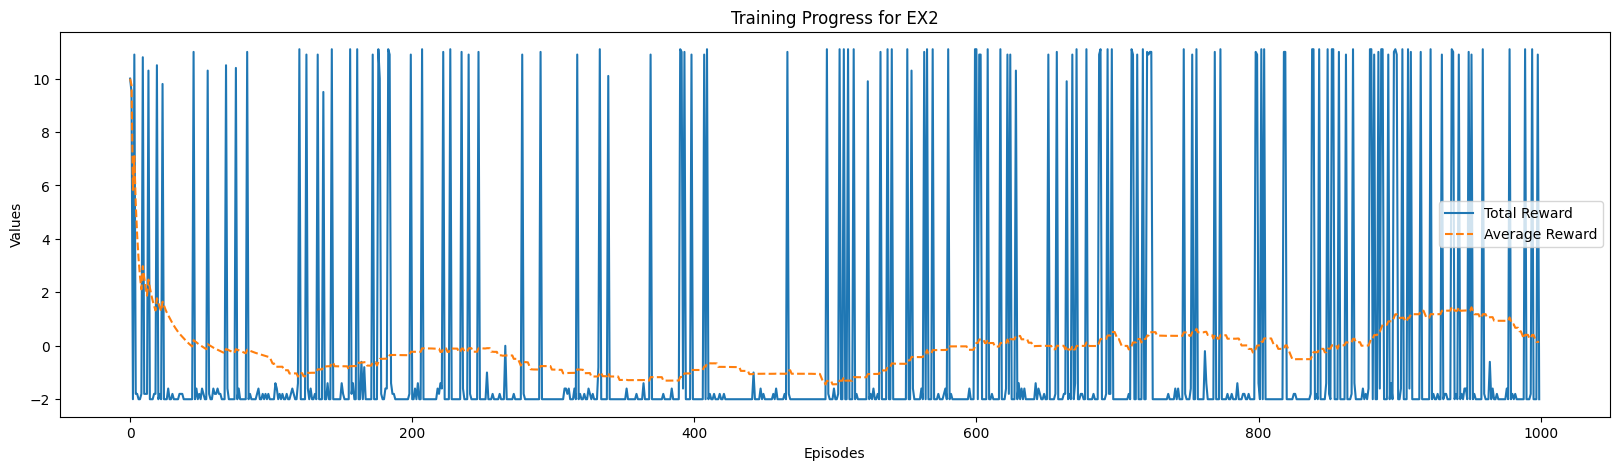

In [ ]:
plt.figure(figsize=(20, 5))
plt.plot(rewards_ex2, label='Total Reward')
plt.plot(avg_rewards_ex2, label='Average Reward', linestyle='--')
plt.xlabel('Episodes')
plt.ylabel('Values')
plt.title('Training Progress for EX2')
plt.legend()
plt.show()

### EX2 - Video test

Recording and Displaying the Video for EX2

In [ ]:
def record_video(env, agent, filename, steps=500):
    # Initialize the environment and agent for recording
    state = convert_observation_to_state(env.reset())  # Reset the environment and convert the initial state
    state = np.reshape(state, [1] + list(agent.state_size))  # Reshape the state to match model input
    done = False

    # Create a video writer object with a specified frame rate (fps)
    with imageio.get_writer(filename, fps=5) as video:
        for _ in range(steps):
            if done:
                break  # Exit loop if the episode ends
            action = agent.act(state)  # Select an action based on the current state
            next_state, reward, done, _ = env.step(action)  # Execute action and get next state, reward, and done flag
            next_state = convert_observation_to_state(next_state)  # Convert the next state to the desired format
            next_state = np.reshape(next_state, [1] + list(agent.state_size))  # Reshape the next state
            video.append_data(env.render(mode='rgb_array'))  # Capture the current frame and add to the video
            state = next_state  # Update the state for the next step

    # Return the embedded video
    return embed_mp4(filename)

video_filename = 'sokoban_ex2.mp4'  # File name for the recorded video
record_video(sok_2, agent_ex2, video_filename)  # Record a video of the agent playing in the environment
embed_mp4(video_filename)  # Embed the recorded video

/usr/local/lib/python3.10/dist-packages/imageio/plugins/ffmpeg.py:727: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  self._proc.stdin.write(im.tostring())


Video for EX2

In [ ]:
video_filename = 'sokoban_ex2.mp4'  # File name for the recorded video
record_video(sok_2, agent_ex2, video_filename)  # Record a video of the agent playing in the environment
embed_mp4(video_filename)  # Embed the recorded video

## EX3 - PUSH & PULL - TWO BOXES

DQN Agent

In [ ]:
class DQNAgent:
    def __init__(self, state_size, action_size, learning_rate=0.001):
        """
        Initialize the DQNAgent with the given state and action sizes and learning rate.

        Parameters:
        state_size (tuple): The shape of the state space.
        action_size (int): The number of possible actions.
        learning_rate (float): The learning rate for the neural network.
        """
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)  # Replay memory to store experiences
        self.gamma = 0.9  # Discount rate for future rewards
        self.epsilon = 1.0  # Initial exploration rate
        self.epsilon_min = 0.3  # Minimum exploration rate
        self.epsilon_decay = 0.995  # Decay rate for exploration
        self.learning_rate = learning_rate  # Learning rate for the neural network
        self.model = self._build_model()  # Build the main model
        self.target_model = self._build_model()  # Build the target model
        self.update_target_model()  # Initialize the target model weights

    def _build_model(self):
        """
        Build the neural network model for the agent.

        Returns:
        model (keras.Model): The compiled neural network model.
        """
        model = Sequential()
        model.add(Conv2D(32, (16,16), strides=(16,16), input_shape=self.state_size, activation='relu'))
        model.add(Conv2D(64, (3,3), activation='relu'))
        model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
        model.add(Flatten())
        model.add(Dense(512, activation='relu'))
        model.add(Dense(128, activation='relu'))
        model.add(Dense(32, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer="adam")
        return model

    def update_target_model(self):
        """
        Update the target model's weights to match the main model's weights.
        """
        self.target_model.set_weights(self.model.get_weights())

    def remember(self, state, action, reward, next_state, done):
        """
        Store a transition in the replay memory.

        Parameters:
        state (np.ndarray): The current state.
        action (int): The action taken.
        reward (float): The reward received.
        next_state (np.ndarray): The next state.
        done (bool): Whether the episode has ended.
        """
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        """
        Choose an action based on the current state.

        Parameters:
        state (np.ndarray): The current state.

        Returns:
        action (int): The action chosen by the agent.
        """
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)  # Explore: choose a random action
        act_values = self.model.predict(state, verbose=0)  # Predict action values
        return np.argmax(act_values[0])  # Exploit: choose the action with the highest value

    def replay(self, batch_size):
        """
        Train the model using a batch of experiences from the replay memory.

        Parameters:
        batch_size (int): The number of experiences to sample from the memory.
        """
        minibatch = random.sample(self.memory, batch_size)  # Sample a minibatch of experiences
        for state, action, reward, next_state, done in minibatch:
            target = self.model.predict(state, verbose=0)  # Predict the target Q-value
            if done:
                target[0][action] = reward  # If done, the target is the reward itself
            else:
                t = self.target_model.predict(next_state, verbose=0)[0]
                target[0][action] = reward + self.gamma * np.amax(t)  # Update target with discounted future reward
            self.model.fit(state, target, epochs=1, verbose=0)  # Train the model
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay  # Decay the exploration rate

    def load(self, name):
        """
        Load the model weights from a file.

        Parameters:
        name (str): The filename of the saved weights.
        """
        self.model.load_weights(name)

    def save(self, name):
        """
        Save the model weights to a file.

        Parameters:
        name (str): The filename to save the weights to.
        """
        self.model.save_weights(name)

Converting observation to state

In [ ]:
def convert_observation_to_state(observation):
    """
    Convert an observation to a state representation.

    Parameters:
    observation (np.ndarray): The observation to convert.

    Returns:
    observation (np.ndarray): The same observation, acting as the state representation.
    """
    return observation

Training function for EX3

In [ ]:
def train_dqn_agent(env, agent, episodes=1000, batch_size=8, success_threshold=-2):
    """
    Train a DQN agent in the specified environment.

    Parameters:
    env (gym.Env): The environment in which the agent will be trained.
    agent (DQNAgent): The DQN agent to be trained.
    episodes (int): The total number of episodes to train the agent.
    batch_size (int): The batch size for experience replay.
    success_threshold (float): The reward threshold to consider an episode successful.

    Returns:
    rewards (list): List of total rewards for each episode.
    avg_rewards (list): List of average rewards over recent episodes.
    """
    rewards = []
    avg_rewards = []
    recent_rewards = deque(maxlen=100)  # Store recent rewards to calculate average and std deviation

    for e in range(episodes):
        start_time = time.time()  # Start timing the episode
        state = convert_observation_to_state(env.reset())  # Reset the environment and convert the state
        state = np.reshape(state, [1] + list(agent.state_size))  # Reshape state to match input shape
        total_reward = 0
        done = False
        step_count = 0

        while not done:
            action = agent.act(state)  # Choose an action based on the current state
            next_state, reward, done, _ = env.step(action)  # Perform the action and get the result
            next_state = convert_observation_to_state(next_state)  # Convert the next state
            next_state = np.reshape(next_state, [1] + list(agent.state_size))  # Reshape next_state to match input shape

            # Store the experience in the agent's memory
            agent.remember(state, action, reward, next_state, done)
            state = next_state  # Update state for the next step
            total_reward += reward  # Accumulate the total reward for this episode
            step_count += 1  # Count the number of steps taken

        # Update the model and add experiences to replay memory every 10 episodes
        if (e + 1) % 10 == 0:
            if len(agent.memory) > batch_size:  # Ensure there are enough experiences to sample
                agent.replay(batch_size)  # Perform experience replay
                agent.update_target_model()  # Update the target model

        # Record the rewards and calculate averages
        rewards.append(total_reward)
        recent_rewards.append(total_reward)
        avg_recent_reward = np.mean(recent_rewards) if recent_rewards else 0  # Calculate average of recent rewards
        std_recent_reward = np.std(recent_rewards) if recent_rewards else 0  # Calculate standard deviation of recent rewards
        avg_rewards.append(avg_recent_reward)

        elapsed_time = time.time() - start_time  # Calculate the time taken for the episode
        if (e + 1) % 10 == 0:
            # Print the results every 10 episodes
            print(f"Episode {e + 1}/{episodes} - Reward: {total_reward}, Avg Reward: {avg_recent_reward}, Std Dev: {std_recent_reward}, Steps: {step_count}, Time: {elapsed_time:.2f}s")

    return rewards, avg_rewards

In [ ]:
#=============== DO NOT DELETE ===============
sok_3 = PushAndPullSokobanEnv(dim_room=(7, 7),num_boxes=2 ,max_steps=500)
# ============================================

Observation space: Box(0.0, 255.0, (112, 112, 3), float32)
Action space: Discrete(13)
Player position:[5 2]
Box location: (4, 1)


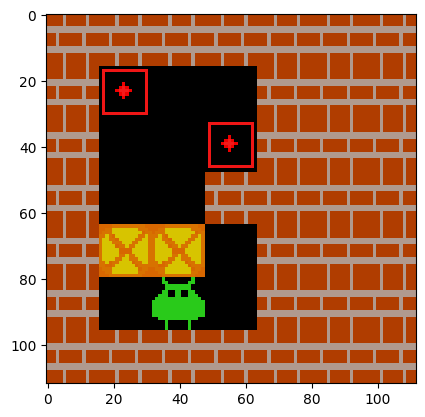

In [ ]:
screen = sok_3.render(mode='rgb_array')
plt.imshow(sok_3.render('rgb_array'))
print_env_det(sok_3)

Training the DQN Agent for EX3

In [ ]:
# Create an instance of the PushAndPullSokobanEnv environment with specific parameters
sok_3 = PushAndPullSokobanEnv(dim_room=(7, 7),num_boxes=2 ,max_steps=30)
# Get the shape of the observation space and the number of actions in the environment
state_size = sok_3.observation_space.shape  # Shape of the state space (e.g., (height, width, channels))
action_size = sok_3.action_space.n  # Number of possible actions in the environment

# Initialize a DQNAgent with the state and action sizes from the environment
agent_ex3 = DQNAgent(state_size, action_size)

# Train the DQN agent in the sok_3 environment
# - episodes: Total number of episodes to train the agent
# - batch_size: Number of experiences to sample from memory for training
# - success_threshold: Reward threshold to consider an episode as successful for adding experiences to the model
rewards_ex3, avg_rewards_ex3 = train_dqn_agent(sok_3, agent_ex3, episodes=5000, batch_size=8, success_threshold=-3)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Episode 10/5000 - Reward: -3.0000000000000013, Avg Reward: -2.900000000000001, Std Dev: 0.30000000000000027, Steps: 30, Time: 8.03s
Episode 20/5000 - Reward: -2.0000000000000004, Avg Reward: -2.8500000000000005, Std Dev: 0.35707142142714265, Steps: 30, Time: 1.45s
Episode 30/5000 - Reward: -3.0000000000000013, Avg Reward: -2.4233333333333342, Std Dev: 2.208420752986673, Steps: 30, Time: 1.90s
Episode 40/5000 - Reward: -2.0000000000000013, Avg Reward: -2.517500000000001, Std Dev: 1.9298817968984532, Steps: 30, Time: 1.36s
Episode 50/5000 - Reward: -3.0000000000000013, Avg Reward: -2.3340000000000014, Std Dev: 2.4743168754223865, Steps: 30, Time: 1.47s
Episode 60/5000 - Reward: -3.0000000000000013, Avg Reward: -2.4450000000000007, Std Dev: 2.2723281013093155, Steps: 30, Time: 2.09s
Episode 70/5000 - Reward: -3.0000000000000013, Avg Reward: -2.524285714285715, Std Dev: 2.1127122523487407, Steps: 30, Time: 1.81s
Episode 80/5000 - Reward: -3.0000000000000013, Avg Reward: -2.5712500000000005

Plotting the Training Progress

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


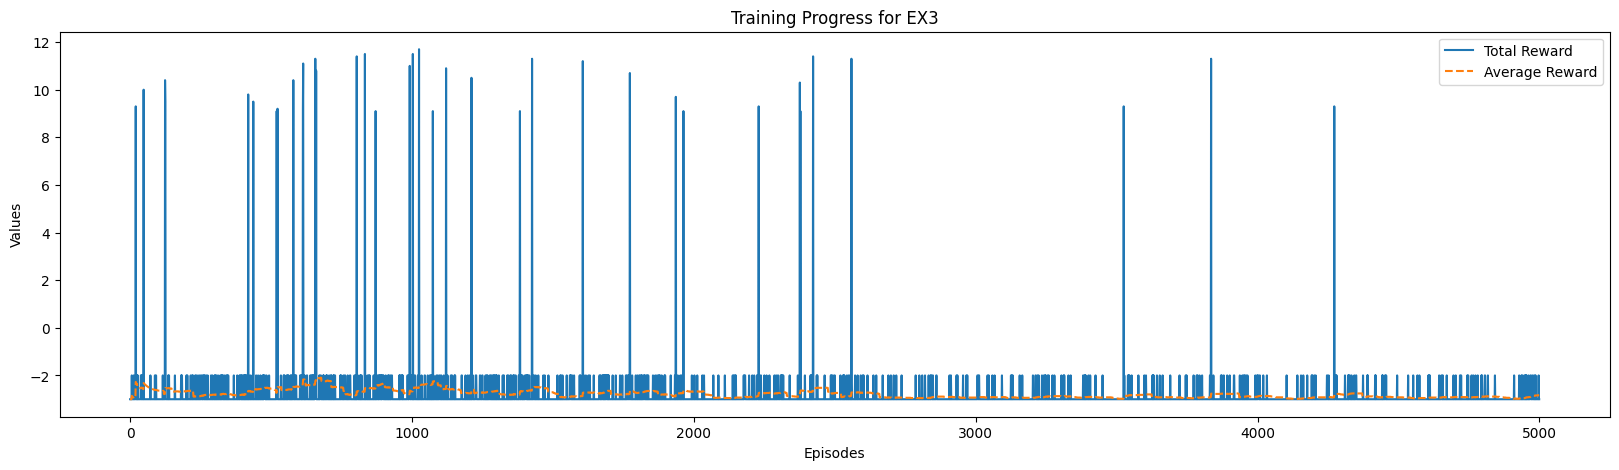

In [ ]:
plt.figure(figsize=(20, 5))
plt.plot(rewards_ex3, label='Total Reward')
plt.plot(avg_rewards_ex3, label='Average Reward', linestyle='--')
plt.xlabel('Episodes')
plt.ylabel('Values')
plt.title('Training Progress for EX3')
plt.legend()
plt.show()

### EX3 - Video test

Recording and Displaying the Video for EX3

In [ ]:
def record_video(env, agent, filename, steps=500):
    # Initialize the environment and agent for recording
    state = convert_observation_to_state(env.reset())  # Reset the environment and convert the initial state
    state = np.reshape(state, [1] + list(agent.state_size))  # Reshape the state to match model input
    done = False

    # Create a video writer object with a specified frame rate (fps)
    with imageio.get_writer(filename, fps=5) as video:
        for _ in range(steps):
            if done:
                break  # Exit loop if the episode ends
            action = agent.act(state)  # Select an action based on the current state
            next_state, reward, done, _ = env.step(action)  # Execute action and get next state, reward, and done flag
            next_state = convert_observation_to_state(next_state)  # Convert the next state to the desired format
            next_state = np.reshape(next_state, [1] + list(agent.state_size))  # Reshape the next state
            video.append_data(env.render(mode='rgb_array'))  # Capture the current frame and add to the video
            state = next_state  # Update the state for the next step

    # Return the embedded video
    return embed_mp4(filename)

video_filename = 'sokoban_ex3.mp4'  # File name for the recorded video
record_video(sok_3, agent_ex3, video_filename)  # Record a video of the agent playing in the environment
embed_mp4(video_filename)  # Embed the recorded video

/usr/local/lib/python3.10/dist-packages/imageio/plugins/ffmpeg.py:727: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  self._proc.stdin.write(im.tostring())
